# HMDA CA 2024 – Filtered SFR Loans  
## EDA, Data Cleaning, Feature Engineering & Baseline Approval Classifier

**Research Question**  
Can we accurately predict whether a housing loan application will be **approved** (True/False) based on applicant characteristics, financial indicators, and property-related information, for typical homebuyers (single-family, non-business use)?

**Data Source and Scope**  

Primary data source is:
- Data available as part of the **Home Mortgage Disclosure Act**
- See: https://ffiec.cfpb.gov/data-browser/data/2024?category=states

To reduce the data record size in order to make the analysis tractable, the raw data was initially filtered prior to import to include only:
- Calendar year 2024
- California data only

**Module Task (Phase 1)**  
- Perform **exploratory data analysis (EDA)** to develop an **initial report**.  
- Use EDA (with tables **and visualizations**) to understand:
  - Distributions of key variables  
  - Relationships between features and the approval decision  
  - Data quality issues (missingness, outliers, inconsistent values)  
- Focus on **data cleaning**, including:
  - Handling missing values (drop vs impute, with justification)  
  - Outlier detection and treatment (keep/drop/cap, with justification)  
- Apply **feature engineering** and prepare both numeric and categorical variables for modeling  
- Train **one baseline ML model** to be used later for comparison with future, optimized models.

> This notebook intentionally stops after establishing a **baseline model**. No model tuning or algorithm comparison is performed in this phase.


In [58]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV


pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

print("Libraries imported.")

Libraries imported.


## 1. Load Filtered HMDA SFR Dataset

This dataset is assumed to have been pre-filtered to:
- Single Family (1–4 Units), site-built (not manufactured)  
- Not primarily for business/commercial purpose  
- Home purchase or refinancing loans only  
- Decisioned underwriting outcomes only (`action_taken` ∈ {1, 2, 3})  



In [2]:
DATA_PATH = "data/state_CA_2024_filtered.csv"

df = pd.read_csv(DATA_PATH, low_memory=False)
print("Shape:", df.shape)
df.head()

Shape: (346350, 100)


,activity_year,lei,derived_msa-md,state_code,county_code,census_tract,conforming_loan_limit,derived_loan_product_type,derived_dwelling_category,derived_ethnicity,derived_race,derived_sex,action_taken,purchaser_type,preapproval,loan_type,loan_purpose,lien_status,reverse_mortgage,open-end_line_of_credit,business_or_commercial_purpose,loan_amount,loan_to_value_ratio,interest_rate,rate_spread,hoepa_status,total_loan_costs,total_points_and_fees,origination_charges,discount_points,lender_credits,loan_term,prepayment_penalty_term,intro_rate_period,negative_amortization,interest_only_payment,balloon_payment,other_nonamortizing_features,property_value,construction_method,occupancy_type,manufactured_home_secured_property_type,manufactured_home_land_property_interest,total_units,multifamily_affordable_units,income,debt_to_income_ratio,applicant_credit_score_type,co-applicant_credit_score_type,applicant_ethnicity-1,applicant_ethnicity-2,applicant_ethnicity-3,applicant_ethnicity-4,applicant_ethnicity-5,co-applicant_ethnicity-1,co-applicant_ethnicity-2,co-applicant_ethnicity-3,co-applicant_ethnicity-4,co-applicant_ethnicity-5,applicant_ethnicity_observed,co-applicant_ethnicity_observed,applicant_race-1,applicant_race-2,applicant_race-3,applicant_race-4,applicant_race-5,co-applicant_race-1,co-applicant_race-2,co-applicant_race-3,co-applicant_race-4,co-applicant_race-5,applicant_race_observed,co-applicant_race_observed,applicant_sex,co-applicant_sex,applicant_sex_observed,co-applicant_sex_observed,applicant_age,co-applicant_age,applicant_age_above_62,co-applicant_age_above_62,submission_of_application,initially_payable_to_institution,aus-1,aus-2,aus-3,aus-4,aus-5,denial_reason-1,denial_reason-2,denial_reason-3,denial_reason-4,tract_population,tract_minority_population_percent,ffiec_msa_md_median_family_income,tract_to_msa_income_percentage,tract_owner_occupied_units,tract_one_to_four_family_homes,tract_median_age_of_housing_units,is_approved
0,2024,01KWVG908KE7RKPTNP46,31084,CA,6037.0,6.037530e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,Race Not Available,Joint,1,1,2,1,1,1,2,2,2,675000.0,80.000,6.625,0.133,2,10965.68,NaN,6335.00,5040.00,NaN,360.0,NaN,NaN,2,2,2,2,845000.0,1,1,3,5,1,NaN,152.0,48,3,9,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2,2,6.0,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,2,2,1,2,2,2,<25,25-34,No,No,1,1,1,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,3528,95.44,98200,93,395,974,59,1
1,2024,01KWVG908KE7RKPTNP46,40140,CA,6065.0,6.065045e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Not Hispanic or Latino,White,Male,1,1,2,1,1,1,2,2,2,765000.0,65.798,6.125,-0.264,2,15076.69,NaN,8860.50,7665.50,7665.5,360.0,NaN,NaN,2,2,2,2,1165000.0,1,1,3,5,1,NaN,NaN,45,2,9,2.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,2,2,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2,2,1,1,2,2,55-64,45-54,No,No,1,1,1,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,1343,28.67,97500,106,425,721,41,1
2,2024,01KWVG908KE7RKPTNP46,40140,CA,6071.0,6.071011e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Joint,White,Joint,1,1,2,1,1,1,2,2,2,205000.0,43.956,6.500,0.242,2,8625.68,NaN,5295.00,4000.00,1000.0,360.0,NaN,NaN,2,2,2,2,455000.0,1,1,3,5,1,NaN,186.0,20%-<30%,2,9,2.0,NaN,NaN,NaN,NaN,1.0,11.0,NaN,NaN,NaN,2,2,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2,2,1,2,2,2,45-54,45-54,No,No,1,1,1,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,3669,32.57,97500,104,933,2430,53,1
3,2024,01KWVG908KE7RKPTNP46,37100,CA,6111.0,6.111008e+09,C,Conventional:First Lien,Single Family (1-4 Units):Site-Built,Hispanic or Latino,White,Joint,1,1,2,1,1,1,2,2,2,475000.0,60.510,6.500,-0.006,2,8071.94,NaN,4263.75,2968.75,2375.0,360.0,NaN,NaN,2,2,2,2,785000.0,1,1,3,5,1,NaN,187.0,20%-<30%,3,9,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2,2,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,2,2,1,2,2,2,35-44,35-44,No,No,1,1,1,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,7185,48.34,125600,112,1898,2379,36,1
4,2024,01KWVG908KE7RKPTNP46,41740,CA,6073.0,6.073007e+09,NC,Conventional:Subordinate Lien,Single Family (1-4 Units)

## 2. Initial Schema Data Review and Target Engineering

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346350 entries, 0 to 346349
Data columns (total 100 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   activity_year                             346350 non-null  int64  
 1   lei                                       346350 non-null  object 
 2   derived_msa-md                            346350 non-null  int64  
 3   state_code                                346350 non-null  object 
 4   county_code                               346081 non-null  float64
 5   census_tract                              345820 non-null  float64
 6   conforming_loan_limit                     346350 non-null  object 
 7   derived_loan_product_type                 346350 non-null  object 
 8   derived_dwelling_category                 346350 non-null  object 
 9   derived_ethnicity                         346350 non-null  object 
 10  derived_race       

In [4]:
# Categorical summary (top-level)
df.describe(include=['object']).T

,count,unique,top,freq
lei,346350,773,549300HW662MN1WU8550,46436
state_code,346350,1,CA,346350
conforming_loan_limit,346350,3,C,305239
derived_loan_product_type,346350,7,Conventional:First Lien,236721
derived_dwelling_category,346350,1,Single Family (1-4 Units):Site-Built,346350
derived_ethnicity,346350,5,Not Hispanic or Latino,189043
derived_race,346350,9,White,165646
derived_sex,346350,4,Joint,148935
debt_to_income_ratio,320747,19,30%-<36%,39427
applicant_age,346350,8,35-44,106982


### 2a. Engineer is_approved Target Definition

The HMDA field `action_taken` captures the outcome of each loan application. The relevant codes are:

- **1 – Loan originated** (formal approval, loan closed)  
- **2 – Application approved but not accepted** (formal approval, applicant did not proceed)  
- **3 – Application denied** (formal denial)  

Other codes (4, 5, 6, 7, 8) represent withdrawn, incomplete, purchased, or pre-approval scenarios and do **not** correspond to a completed approval/denial decision. The uploaded filtered file has already filtered out these code, but we verify and create the target below.

Our research question is specifically about **approval (True/False)**, not about whether the loan ultimately funded or was withdrawn. Therefore, we restrict our modeling target to **decisioned underwriting outcomes only**.

We define a binary target:
- `is_approved = 1` if `action_taken` ∈ {1, 2}  
- `is_approved = 0` if `action_taken` = 3  



In [5]:
df["action_taken"].value_counts().sort_index()

action_taken
1    287913
2     13745
3     44692
Name: count, dtype: int64

In [6]:
# Create/confirm binary target
if "is_approved" not in df.columns:
    df["is_approved"] = df["action_taken"].apply(lambda x: 1 if x in [1, 2] else 0)

df["is_approved"].value_counts(normalize=True) * 100

is_approved
1    87.09629
0    12.90371
Name: proportion, dtype: float64

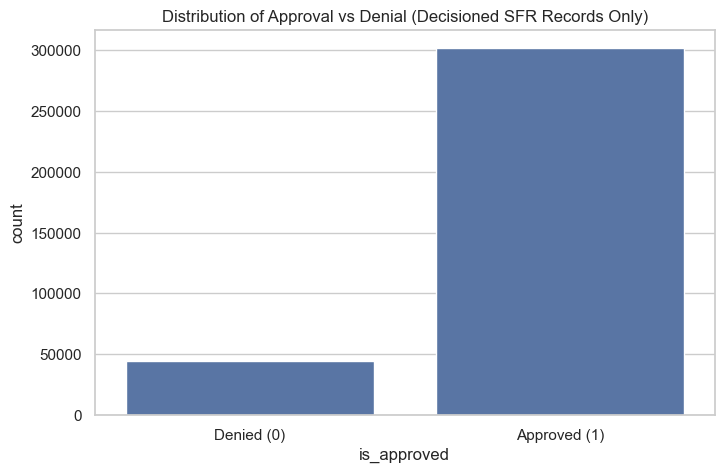

In [7]:
sns.countplot(x="is_approved", data=df)
plt.title("Distribution of Approval vs Denial (Decisioned SFR Records Only)")
plt.xticks([0, 1], ["Denied (0)", "Approved (1)"])
plt.show()

#### Remove action_taken column

This is now redundant with the is_approved field.



In [8]:
df = df.drop(columns=["action_taken"], errors="ignore")
print("action_taken replaced by is_approved. Remaining column count:", df.shape[1])

action_taken replaced by is_approved. Remaining column count: 99


## 3. Identify Drop Columns

Analyze source data to determine if source data columns can be dropped from the data analysis.


### 3a. Drop Irrelevant Columns

Some columns are not relevant to the data analysis and can be safely removed:
- **lei** - Identifier for reporting institution, not an applicant attribute and not predictive
- **preapproval** - indicates if the loan or application involved a request for a preapproval of a home purchase loan under a preapproval program
- **derived_dwelling_category**	 - data was pre-filtered for Single Family homes only, so column only contains 1 value.
- **state_code** - data was pre-filtered to consider CA only, just to limit the size of the source data and reduce processing time.  Column contains only 1 value.
- **purchaser_type** - assigned only after loan origination and sale in the secondary market, which occurs after the underwriting approval decision and would introduce outcome leakage if included in analysis
- **business_or_commercial_purpose** - data has been pre-filtered to include only cases where purpose is not commercial.  Not relevant for data analysis as column will contain only 1 value.
- **manufactured_home_secured_property_type** - data has been pre-filtered to include only single family homes.  Manufactured homes are not relevant to the data analysis.
- **manufactured_home_land_property_interest** -  data has been pre-filtered to include only single family homes.  Manufactured homes are not relevant to the data analysis.


Complete description of the source data attributes can be found here: https://ffiec.cfpb.gov/documentation/publications/loan-level-datasets/lar-data-fields#interest_rate

In [9]:
df = df.drop(columns=["lei", "preapproval", "derived_dwelling_category", "state_code", "purchaser_type", "business_or_commercial_purpose", "manufactured_home_secured_property_type", "manufactured_home_land_property_interest" ], errors="ignore")
print("8 Columns dropped. Remaining column count:", df.shape[1])


8 Columns dropped. Remaining column count: 91


### 3b. Drop Columns - Denial Reason

  This column should be excluded from modeling because it is only populated after underwriting has issued a denial decision, and cannot help predict approval at submission time.
  - Valid values include:
    - 1 → Debt-to-income ratio
    - 2 → Employment history
    - 3 → Credit history
    - 4 → Collateral
    - 5 → Insufficient cash
    - 6 → Unverifiable info
    - 7 → Application incomplete
    - 8 → Mortgage insurance denied
    - 9 → Other
    - 10 → Not applicable

We observe below that denial_reason-1 **always** = 10 (Not Applicable) when the loan is approved, but **never** = 10 when loan is denied.


Counts: is_approved vs denial_reason-1


denial_reason-1,1,2,3,4,5,6,7,8,9,10,1111
is_approved,,,,,,,,,,,
0,16959,535,4538,6300,3415,2631,5940,22,4350,0,2
1,0,0,0,0,0,0,0,0,0,301658,0


---------------------------------
Count of denial_reason-1 == NaN 0
P(denial_reason-1 == 10 | DENIED): 0.0000%
P(denial_reason-1 == 10 | APPROVED): 100.0000%
---------------------------------


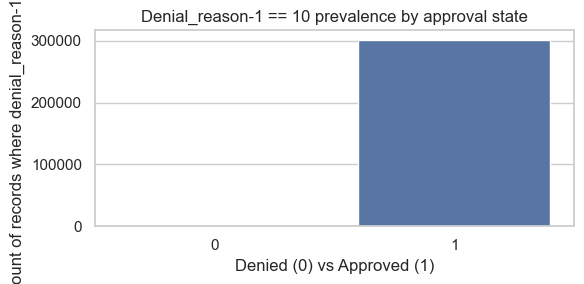

In [10]:
# Filter to only rows where denial_reason-1 == 10
dr10 = df[df["denial_reason-1"] == 10]

# Show actual counts for this condition
ct = pd.crosstab(df["is_approved"], df["denial_reason-1"])
print("Counts: is_approved vs denial_reason-1")
display(ct)

# Conditional rates wrt approval at submission
# P(denial_reason-1 == 10 | is_approved == 0) and P(... | is_approved == 1)
denied_cond_rate = df[df["is_approved"] == 0]["denial_reason-1"].eq(10).mean() * 100
approved_cond_rate = df[df["is_approved"] == 1]["denial_reason-1"].eq(10).mean() * 100
print("---------------------------------")
print("Count of denial_reason-1 == NaN", df["denial_reason-1"].isna().sum())
print(f"P(denial_reason-1 == 10 | DENIED): {denied_cond_rate:.4f}%")
print(f"P(denial_reason-1 == 10 | APPROVED): {approved_cond_rate:.4f}%")
print("---------------------------------")

# 4. Visualize prevalence of denial_reason-1 == 10 across approval states,
# ensuring both 0 and 1 appear on the x-axis even if one count is 0.
if not dr10.empty:
    plot = dr10.groupby("is_approved")["denial_reason-1"].count().reset_index()
    
    # Ensure both 0 and 1 are present
    plot = plot.set_index("is_approved").reindex([0, 1], fill_value=0).reset_index()
    plot.rename(columns={"index": "is_approved"}, inplace=True)

    plt.figure(figsize=(6, 3))
    sns.barplot(data=plot, x="is_approved", y="denial_reason-1")
    plt.xlabel("Denied (0) vs Approved (1)")
    plt.ylabel("Count of records where denial_reason-1 = 10")
    plt.title("Denial_reason-1 == 10 prevalence by approval state")
    plt.tight_layout()
    plt.show()
else:
    # If empty, still show 0 and 1 on chart for consistency
    plot = pd.DataFrame({"is_approved": [0, 1], "denial_reason-1": [0, 0]})
    
    plt.figure(figsize=(6, 3))
    sns.barplot(data=plot, x="is_approved", y="denial_reason-1")
    plt.xlabel("Denied (0) vs Approved (1)")
    plt.ylabel("Count of records where denial_reason-1 = 10")
    plt.title("No denied records where denial_reason-1 = 10")
    plt.tight_layout()
    plt.show()



#### Drop all Denial Reason columns below.


In [11]:
# Column count BEFORE drop
cols_before = df.shape[1]
print("Column count BEFORE dropping Denial Reason cols:", cols_before)

# Identify denial reason columns by substring match 
drop_cols = [c for c in df.columns if "denial_reason" in c.lower()]

# Drop them
df = df.drop(columns=drop_cols, errors="ignore")

# Column count AFTER drop
cols_after = df.shape[1]
print("Column count AFTER dropping Denial Reason cols:", cols_after)
print("Columns dropped:", drop_cols)


Column count BEFORE dropping Denial Reason cols: 91
Column count AFTER dropping Denial Reason cols: 87
Columns dropped: ['denial_reason-1', 'denial_reason-2', 'denial_reason-3', 'denial_reason-4']


### 3c. Drop Columns - Approval only attributes

Some columns can only logically have populated values when the loan is approved (i.e. the loan terms).  As this data cannot be known in advance of the loan decision making we are attempting to model they should be removed.  We can see below that these values are always NA when loan status = Denied.  Even when loan status is Approved, there is a high level of missingness in certain cases.


In [12]:

# Formatting options
pd.set_option("display.float_format", "{:.6f}".format)
pd.set_option("display.max_rows", None)

# 1. Select cohorts by approval status
denied = df[df["is_approved"] == 0].copy()
approved = df[df["is_approved"] == 1].copy()

# 2. Define the specific columns to analyze
cols = [
    "total_loan_costs", 
    "rate_spread", 
    "interest_rate", 
    "origination_charges", 
    "discount_points", 
    "lender_credits", 
    "total_points_and_fees"
]

# 3. Compute missing % for both cohorts
missing_pct_denied = denied[cols].isna().mean() * 100
missing_pct_approved = approved[cols].isna().mean() * 100

# 4. Combine into a quartile-style report (but for missing %)
report = pd.DataFrame({
    "column": cols,
    "missing_pct_denied": missing_pct_denied.values,
    "missing_pct_approved": missing_pct_approved.values
})

# 5. Sort by denied % (or change to approved if preferred)
report = report.sort_values("missing_pct_denied", ascending=False).reset_index(drop=True)

print("Missing % for selected financial columns (by approval state):")
display(report)


Missing % for selected financial columns (by approval state):


,column,missing_pct_denied,missing_pct_approved
0,total_loan_costs,100.000000,12.147200
1,rate_spread,100.000000,4.201115
2,interest_rate,100.000000,0.112710
3,origination_charges,100.000000,9.944043
4,discount_points,100.000000,57.751493
5,lender_credits,100.000000,61.778570
6,total_points_and_fees,100.000000,99.110251


#### Drop the Loan Approval dependent columns

This includes:
- total_loan_costs
- rate_spread
- interest_rate
- origination_charges
- discount_points
- lender_credits
- total_points_and_fees


In [13]:
cols_before = df.shape[1]
print("Column count BEFORE dropping Loan Approval cols:", cols_before)
df = df.drop(columns=[c for c in cols if c in df.columns])
cols_after = df.shape[1]
print("Column count AFTER dropping Loan Approval cols:", cols_after)
print("Columns dropped:", cols)



Column count BEFORE dropping Loan Approval cols: 87
Column count AFTER dropping Loan Approval cols: 80
Columns dropped: ['total_loan_costs', 'rate_spread', 'interest_rate', 'origination_charges', 'discount_points', 'lender_credits', 'total_points_and_fees']


## 4. Missing Data Analysis & Strategy

We first analyze missing values, then visualize the top columns by missingness.  
After that, we decide whether to **drop rows** or **impute values**.


### 4a. Missing Data Analysis - Ethnicity



In [14]:
def profile_missingness(df, columns, top_n=20):

    # Compute missing counts and percentages for specified columns
    missing_counts = df[columns].isna().sum().sort_values(ascending=False)
    missing_pct = (missing_counts / len(df) * 100).round(2)

    missing_df = pd.DataFrame({
        "missing_count": missing_counts,
        "missing_pct": missing_pct
    })

    # Plot missing % for the top N columns
    plot_df = missing_df.head(top_n).reset_index().rename(columns={"index": "column"})
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=plot_df, x="missing_pct", y="column")
    plt.xlabel("Missing %")
    plt.ylabel("Column")
    plt.title("Missingness Percentage (Top Columns)")
    plt.tight_layout()
    plt.show()

    # Return the missingness table (top N rows)
    return missing_df.head(top_n)



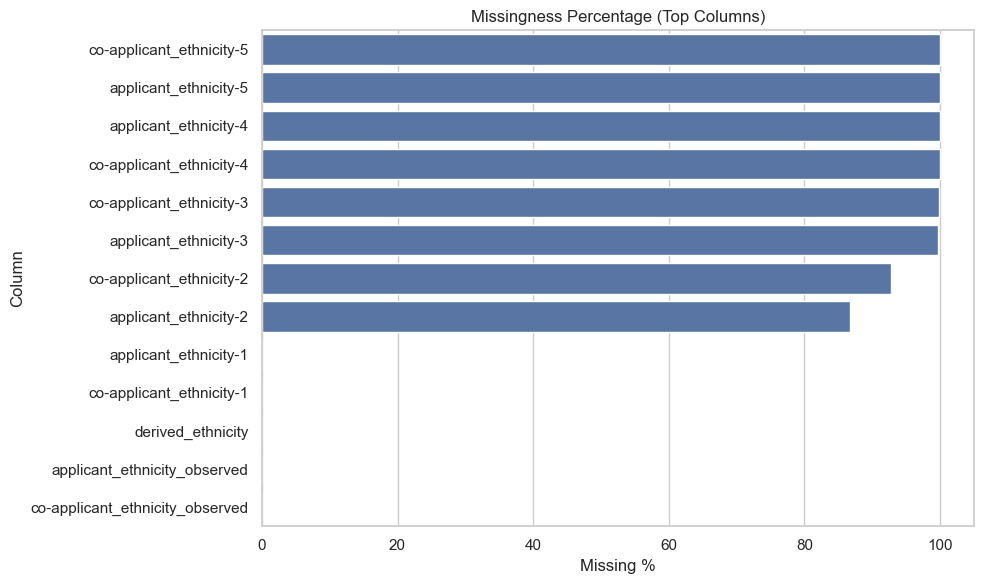

,missing_count,missing_pct
co-applicant_ethnicity-5,346350,100.000000
applicant_ethnicity-5,346349,100.000000
applicant_ethnicity-4,346337,100.000000
co-applicant_ethnicity-4,346335,100.000000
co-applicant_ethnicity-3,346015,99.900000
applicant_ethnicity-3,345536,99.760000
co-applicant_ethnicity-2,321249,92.750000
applicant_ethnicity-2,300234,86.690000
applicant_ethnicity-1,237,0.070000
co-applicant_ethnicity-1,95,0.030000


In [15]:
# Select only columns containing the string "ethnicity" (case-insensitive)
ethnicity_cols = [c for c in df.columns if "ethnicity" in c.lower()]

out = profile_missingness(df, ethnicity_cols)
display(out)

#### Exclusion of Ethnicity fields

The individual fields of ethnicity-1, ethnicity-2, ethnicity-3, etc are aggregated into the derived_ethnicity field.

Given the high degree of missingness in most of the sub-categories, only derived_ethnicity field will be retained for data analysis as this is an aggregated value with 0% missing data.



In [16]:
# Count columns before dropping
cols_before = df.shape[1]
print("Column count BEFORE drop:", cols_before)

# Identify ethnicity checkbox columns with >0% missing
drop_cols = [c for c in df.columns if "ethnicity" in c.lower() and df[c].isna().mean()*100 > 0]

# Drop those columns
df = df.drop(columns=drop_cols)

# Count columns after dropping
cols_after = df.shape[1]
print("Column count AFTER drop:", cols_after)

print("Dropped high-missing ethnicity checkbox columns:", drop_cols)


Column count BEFORE drop: 80
Column count AFTER drop: 70
Dropped high-missing ethnicity checkbox columns: ['applicant_ethnicity-1', 'applicant_ethnicity-2', 'applicant_ethnicity-3', 'applicant_ethnicity-4', 'applicant_ethnicity-5', 'co-applicant_ethnicity-1', 'co-applicant_ethnicity-2', 'co-applicant_ethnicity-3', 'co-applicant_ethnicity-4', 'co-applicant_ethnicity-5']


### 4b. Missing Data Analysis - Race



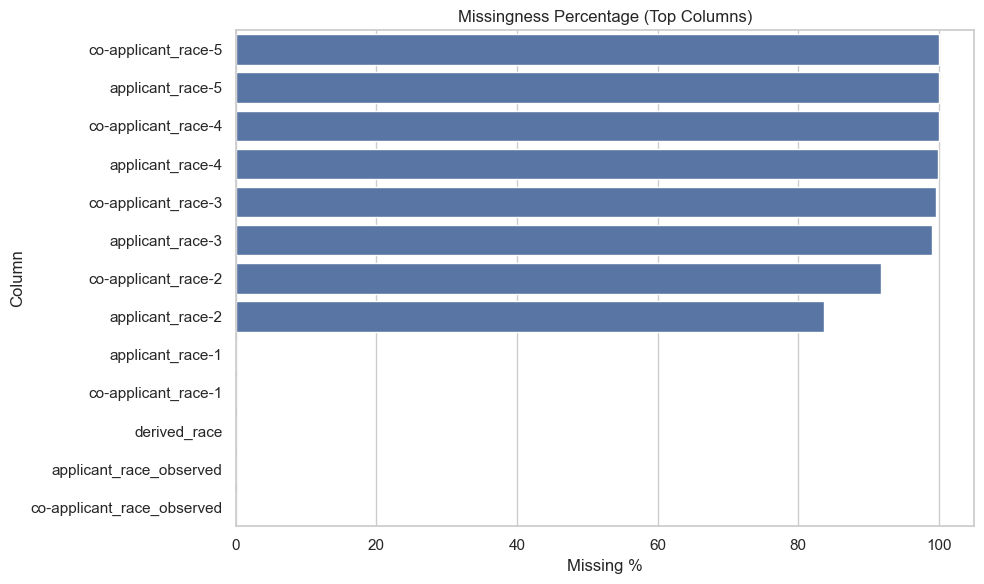

,missing_count,missing_pct
co-applicant_race-5,346311,99.990000
applicant_race-5,346269,99.980000
co-applicant_race-4,346173,99.950000
applicant_race-4,346006,99.900000
co-applicant_race-3,344684,99.520000
applicant_race-3,342915,99.010000
co-applicant_race-2,317648,91.710000
applicant_race-2,289554,83.600000
applicant_race-1,111,0.030000
co-applicant_race-1,64,0.020000


In [17]:
# Select only columns containing the string "race" (case-insensitive)
race_cols = [c for c in df.columns if "race" in c.lower()]

out = profile_missingness(df, race_cols)
display(out)

#### Exclusion of Race fields

Similar to enthnicity the individual fields of race-1, race-2, race-3, etc are aggregated into the derived_race field.

Given the high degree of missingness in most of the sub-categories, only derived_race field will be retained for data analysis as this is an aggregated value with 0% missing data.



In [18]:
# Count columns before dropping
cols_before = df.shape[1]
print("Column count BEFORE drop:", cols_before)

# Identify race checkbox columns with >0% missing
drop_cols = [c for c in df.columns if "race" in c.lower() and df[c].isna().mean()*100 > 0]

# Drop those columns
df = df.drop(columns=drop_cols)

# Count columns after dropping
cols_after = df.shape[1]
print("Column count AFTER drop:", cols_after)

print("Dropped high-missing race checkbox columns:", drop_cols)


Column count BEFORE drop: 70
Column count AFTER drop: 60
Dropped high-missing race checkbox columns: ['applicant_race-1', 'applicant_race-2', 'applicant_race-3', 'applicant_race-4', 'applicant_race-5', 'co-applicant_race-1', 'co-applicant_race-2', 'co-applicant_race-3', 'co-applicant_race-4', 'co-applicant_race-5']


### 4c. Missing Data Analysis - Automated Underwriting System (aus)



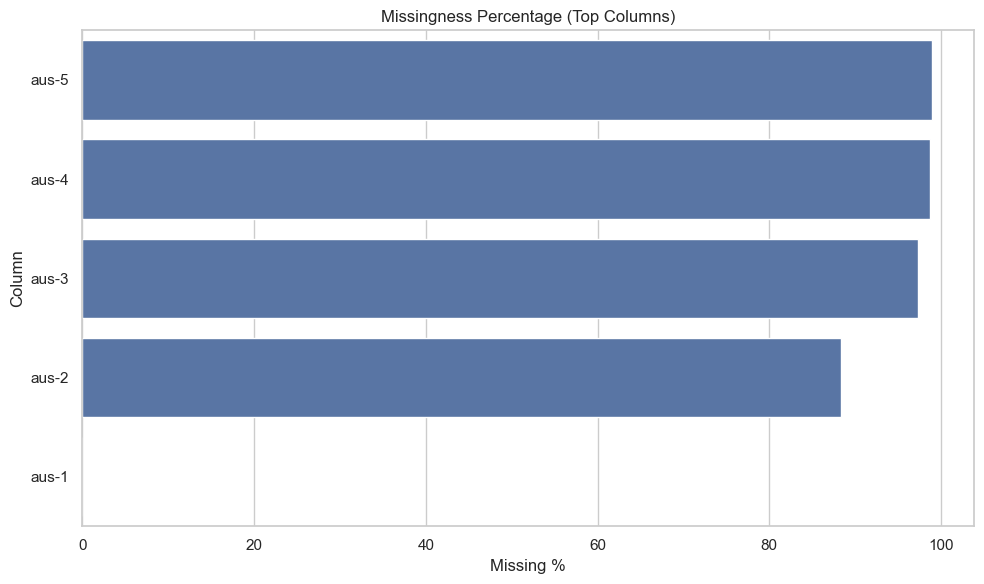

,missing_count,missing_pct
aus-5,342515,98.890000
aus-4,342043,98.760000
aus-3,337220,97.360000
aus-2,306062,88.370000
aus-1,0,0.000000


In [19]:
# Select only columns containing the string "race" (case-insensitive)
aus_cols = [c for c in df.columns if "aus-" in c.lower()]

out = profile_missingness(df, aus_cols)
display(out)

In [20]:
# Count columns before dropping
cols_before = df.shape[1]
print("Column count BEFORE drop:", cols_before)

# Identify race checkbox columns with >5% missing
drop_cols = [c for c in df.columns if "aus-" in c.lower() and df[c].isna().mean()*100 > 5]

# Drop those columns
df = df.drop(columns=drop_cols)

# Count columns after dropping
cols_after = df.shape[1]
print("Column count AFTER drop:", cols_after)

print("Dropped high-missing aus checkbox columns:", drop_cols)


Column count BEFORE drop: 60
Column count AFTER drop: 56
Dropped high-missing aus checkbox columns: ['aus-2', 'aus-3', 'aus-4', 'aus-5']


### 4d. Missing Data Analysis - Other

Review the remaining columns for missingness.  Determine which can be dropped.


In [21]:
# Missing values per column
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(df) * 100).round(2)

# Build report and filter to only columns with missing_pct > 0
missing_df = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_pct": missing_pct
})
missing_df = missing_df[missing_df["missing_pct"] > 0]  # <- keep only non-zero missingness

# Print / display top 20 of remaining columns
missing_df.head(20)


,missing_count,missing_pct
multifamily_affordable_units,346350,100.000000
prepayment_penalty_term,337312,97.390000
intro_rate_period,289576,83.610000
co-applicant_age_above_62,162559,46.930000
debt_to_income_ratio,25603,7.390000
income,17958,5.180000
loan_to_value_ratio,16462,4.750000
property_value,8641,2.490000
loan_term,6327,1.830000
census_tract,530,0.150000


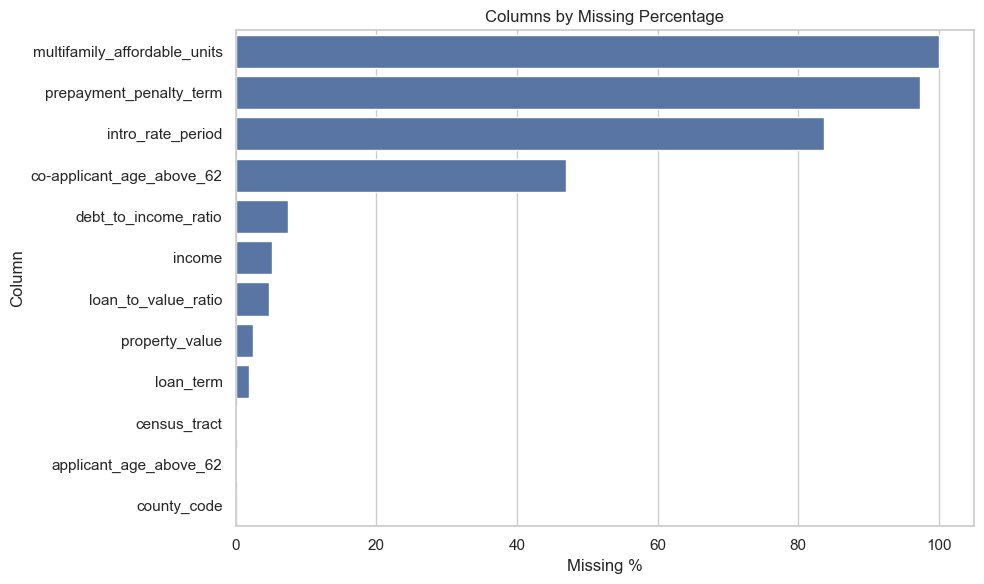

In [22]:
# Visualize top 20 columns by missing percentage
top_missing = missing_df.head(20).reset_index().rename(columns={"index": "column"})
plt.figure(figsize=(10, 6))
sns.barplot(data=top_missing, x="missing_pct", y="column")
plt.xlabel("Missing %")
plt.ylabel("Column")
plt.title("Columns by Missing Percentage")
plt.tight_layout()
plt.show()

In [23]:

# Compute missing % on the full cleaned dataframe
missing_pct = df.isna().mean() * 100

# Identify columns to drop (exclude target from this rule)
drop_cols = [c for c in df.columns if missing_pct[c] > 10 and c != "is_approved"]

# Print column count before/after
print("Column count BEFORE 10% missingness drop:", df.shape[1])

# Drop high-missingness columns
df = df.drop(columns=drop_cols)

print("Column count AFTER 10% missingness drop:", df.shape[1])
print("Columns dropped (missing >10%):", drop_cols)
print("Max remaining missing %:", missing_pct[df.columns].max())


Column count BEFORE 10% missingness drop: 56
Column count AFTER 10% missingness drop: 52
Columns dropped (missing >10%): ['prepayment_penalty_term', 'intro_rate_period', 'multifamily_affordable_units', 'co-applicant_age_above_62']
Max remaining missing %: 7.392233290024541


### Data Schema after dropped columns

Source data is reduced to 55 columns from original 100.


In [24]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346350 entries, 0 to 346349
Data columns (total 52 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   activity_year                      346350 non-null  int64  
 1   derived_msa-md                     346350 non-null  int64  
 2   county_code                        346081 non-null  float64
 3   census_tract                       345820 non-null  float64
 4   conforming_loan_limit              346350 non-null  object 
 5   derived_loan_product_type          346350 non-null  object 
 6   derived_ethnicity                  346350 non-null  object 
 7   derived_race                       346350 non-null  object 
 8   derived_sex                        346350 non-null  object 
 9   loan_type                          346350 non-null  int64  
 10  loan_purpose                       346350 non-null  int64  
 11  lien_status                        3463

### 4e. Missing Data Imputation Strategy

For this phase, we adopt the following approach:

- **Numeric features**   
  - Median imputation is chosen over mean due to its robustness to outliers.

- **Categorical features**:  
  - We impute with the **mode** (most frequent category) or introduce a separate `"Missing"` category, which preserves all records and allows the model to learn any patterns associated with missingness.

This strategy balances **data retention** with **model reliability** and is appropriate for a baseline model.


#### Remaining Missingness after dropped columns

- Only 8 columns still contain any missing data.
- We will impute the missing values accordingly, since the max % missing is 7.39.  As this is below as reasonable 10% threshold, we prefer to retain this cohort of data through imputation rather than dropped the data rows with missing values.


In [25]:
# Missing values per column
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(df) * 100).round(2)

# Build report and filter to only columns with missing_pct > 0
missing_df = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_pct": missing_pct
})
missing_df = missing_df[missing_df["missing_pct"] > 0]  # <- keep only non-zero missingness

# Print / display top 20 of remaining columns
missing_df.head(20)


,missing_count,missing_pct
debt_to_income_ratio,25603,7.390000
income,17958,5.180000
loan_to_value_ratio,16462,4.750000
property_value,8641,2.490000
loan_term,6327,1.830000
census_tract,530,0.150000
applicant_age_above_62,460,0.130000
county_code,269,0.080000


#### Assign median or mode to missing data


In [26]:
# Example: ensure no missing target
df = df[df["is_approved"].notna()].copy()

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != "is_approved"]

categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

# Median imputation for numeric columns
for col in numeric_cols:
    if df[col].isna().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

# Mode / 'Missing' imputation for categorical columns
for col in categorical_cols:
    if df[col].isna().any():
        mode_val = df[col].mode(dropna=True)
        if len(mode_val) > 0:
            df[col] = df[col].fillna(mode_val[0])
        else:
            df[col] = df[col].fillna("Missing")

# Confirm missingness handled
(df.isna().sum() == 0).all()

np.True_

In [27]:
# Select categorical columns (object dtype)
categorical_cols = df.select_dtypes(include=["object", "category"]).columns

# Find which of those contain the value "Missing"
cols_with_missing_literal = [col for col in categorical_cols if (df[col] == "Missing").any()]

# Report results
if cols_with_missing_literal:
    print("Categorical columns containing the literal value 'Missing':")
    for col in cols_with_missing_literal:
        count = (df[col] == "Missing").sum()
        pct = count / len(df) * 100
        print(f"- {col}: {count} rows ({pct:.4f}%)")
else:
    print("No categorical columns were assigned the literal value 'Missing'.")


No categorical columns were assigned the literal value 'Missing'.


## 5. Outlier Analysis

We now identify potential outliers in key numeric variables and decide whether to **keep**, **drop**, or **cap** them.

We will:
- Focus on the numerically important fields (when present), such as:  
  - `loan_amount`, `income`, `property_value`, `loan_to_value_ratio`,  `loan_term`  
- Use the **IQR rule** to flag extreme values.  
- Visualize distributions with boxplots and histograms.  
- Decide on a treatment strategy and justify it.


In [28]:
# Select key numeric columns for outlier analysis
# (debt_to_income_ratio is object/categorical in this dataset, so we exclude it here)
key_numeric_candidates = [
    "loan_amount",
    "income",
    "property_value",
    "loan_to_value_ratio",
    "loan_term",
]

key_numeric = [c for c in key_numeric_candidates if c in df.columns]
print("Numeric features included in outlier analysis:", key_numeric)


Numeric features included in outlier analysis: ['loan_amount', 'income', 'property_value', 'loan_to_value_ratio', 'loan_term']


Column count BEFORE outlier capping: 346350

IQR-based outlier summary (categories preserve skew for modeling):
 #             feature            Q1             Q3           IQR    lower_bound    upper_bound  outlier_count outlier_pct     min_value        max_value
 0         loan_amount 375000.000000  765000.000000 390000.000000 -210000.000000 1350000.000000          23854    6.887253   5000.000000  50005000.000000
 1              income    118.000000     265.000000    147.000000    -102.500000     485.500000          27480    7.934171 -18010.000000    200000.000000
 2      property_value 525000.000000 1125000.000000 600000.000000 -375000.000000 2025000.000000          25972    7.498773   5000.000000 999995000.000000
 3 loan_to_value_ratio     69.136000      95.000000     25.864000      30.340000     133.796000          13094    3.780569      0.010000     63668.816000
 4           loan_term    360.000000     360.000000      0.000000     360.000000     360.000000          18119    5.23

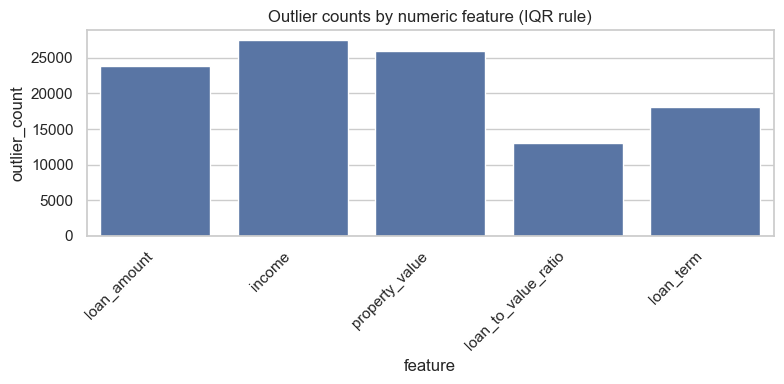

In [29]:
# 5.2 IQR-based outlier detection for selected numeric features with min/max included

outlier_rows = []

for col in key_numeric:
    series = df[col].dropna()

    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    mask_outlier = (series < lower_bound) | (series > upper_bound)
    outlier_count = mask_outlier.sum()
    outlier_pct = (outlier_count / len(series)) * 100

    outlier_rows.append({
        "#": key_numeric.index(col),
        "feature": col,
        "Q1": f"{q1:.6f}",
        "Q3": f"{q3:.6f}",
        "IQR": f"{iqr:.6f}",
        "lower_bound": f"{lower_bound:.6f}",
        "upper_bound": f"{upper_bound:.6f}",
        "outlier_count": outlier_count,
        "outlier_pct": f"{outlier_pct:.6f}",
        "min_value": f"{series.min():.6f}",
        "max_value": f"{series.max():.6f}",
    })

outlier_df = pd.DataFrame(outlier_rows).sort_values("#")

print("Column count BEFORE outlier capping:", len(series))
print("\nIQR-based outlier summary (categories preserve skew for modeling):")

with pd.option_context('display.max_rows', None, 'display.expand_frame_repr', False):
    print(outlier_df.to_string(index=False))
    
plt.figure(figsize=(8, 4))
sns.barplot(data=outlier_df, x="feature", y="outlier_count")
plt.xticks(rotation=45, ha="right")
plt.title("Outlier counts by numeric feature (IQR rule)")
plt.tight_layout()
plt.show()


Numeric features included in outlier visualization: ['loan_amount', 'income', 'property_value', 'loan_to_value_ratio', 'loan_term']


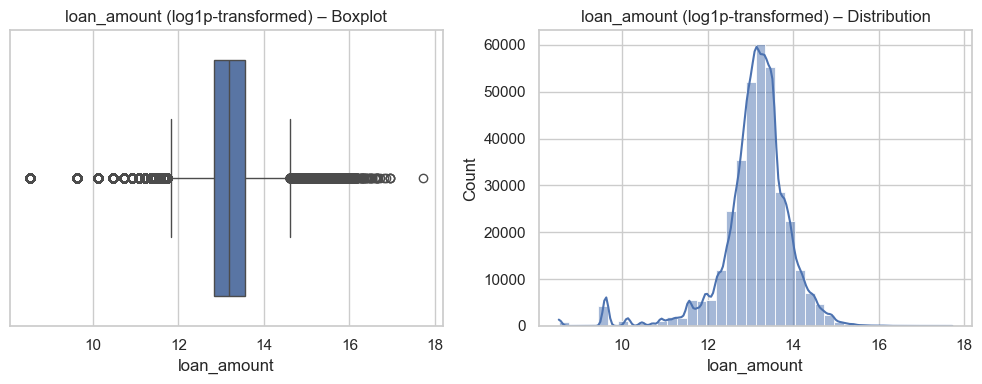

C:\Users\joshd\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\joshd\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


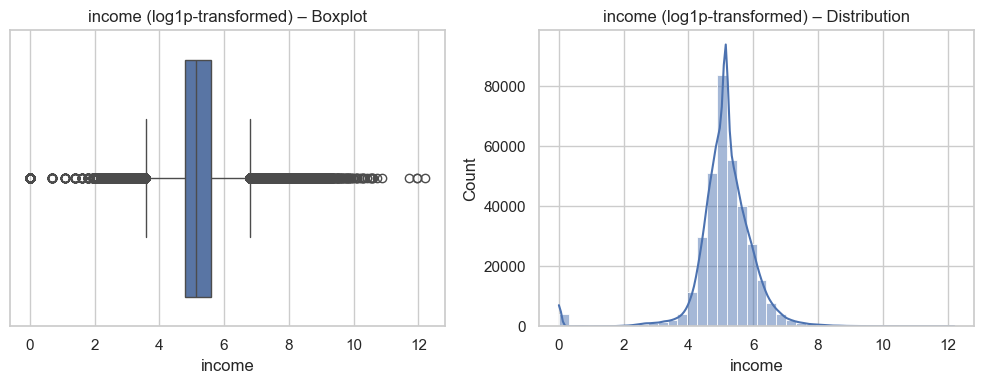

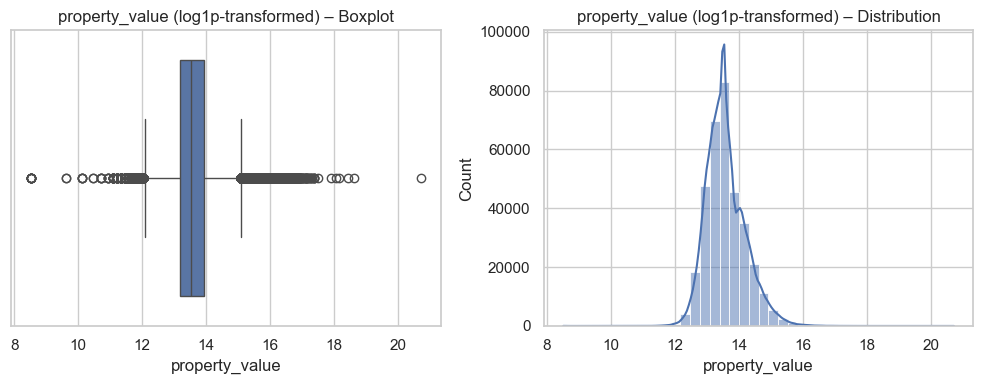

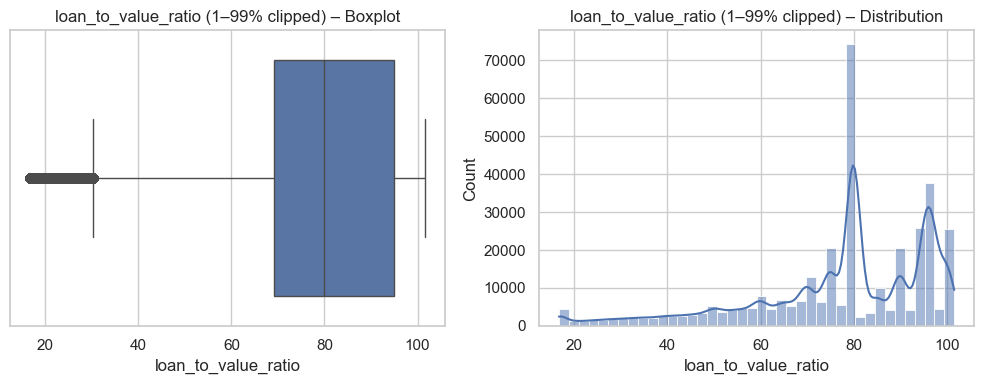

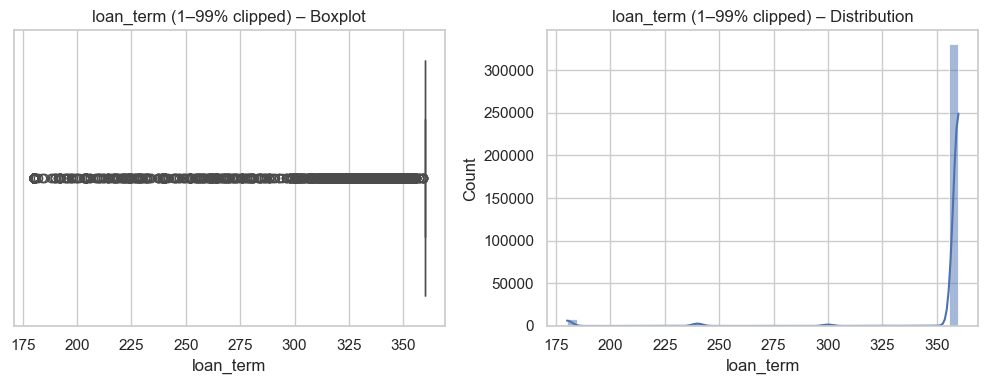

In [30]:
# 5.3 Univariate distributions: boxplots + histograms for each numeric feature

key_numeric = [c for c in key_numeric_candidates if c in df.columns]
print("Numeric features included in outlier visualization:", key_numeric)

# Helper: choose a visualization transform for each column (without changing df)
def make_plot_series(col, series):
    """
    Returns (plot_series, transform_label) for a given numeric column.
    - Uses log1p for heavily skewed 'amount'-type columns.
    - Uses 1–99% clipping for others.
    """
    series = series.dropna()

    # Columns likely to be highly right-skewed currency/amounts
    log_candidates = {"loan_amount", "income", "property_value"}
    
    if col in log_candidates:
        plot_series = np.log1p(series)  # log(1 + x), safe for zeros
        label = "log1p-transformed"
    else:
        lower = series.quantile(0.01)
        upper = series.quantile(0.99)
        plot_series = series.clip(lower, upper)
        label = "1–99% clipped"
    
    return plot_series, label

# Boxplot + histogram for each numeric feature (on transformed scale)
for col in key_numeric:
    raw = df[col]
    plot_series, t_label = make_plot_series(col, raw)

    plt.figure(figsize=(10, 4))
    
    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x=plot_series)
    plt.title(f"{col} ({t_label}) – Boxplot")
    plt.xlabel(col)

    # Histogram + KDE
    plt.subplot(1, 2, 2)
    sns.histplot(plot_series, bins=40, kde=True)
    plt.title(f"{col} ({t_label}) – Distribution")
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()



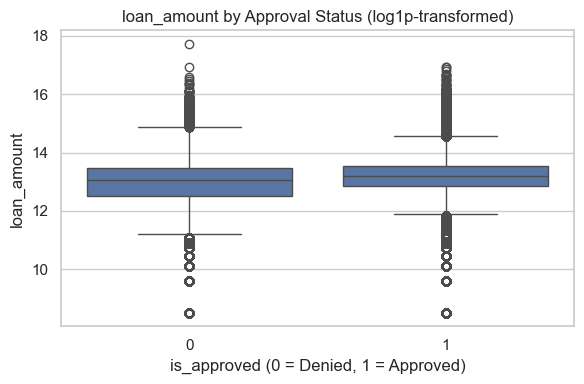

C:\Users\joshd\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\joshd\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


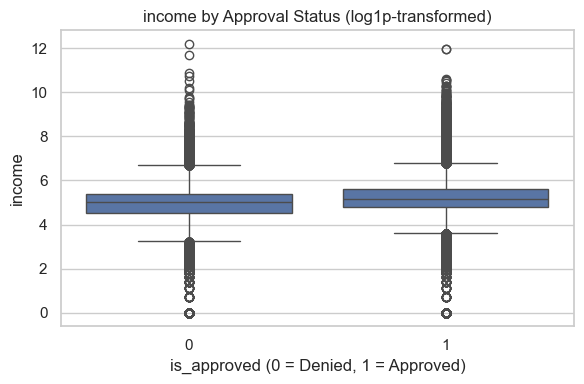

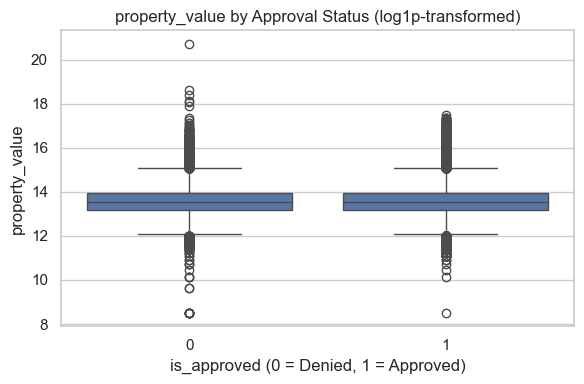

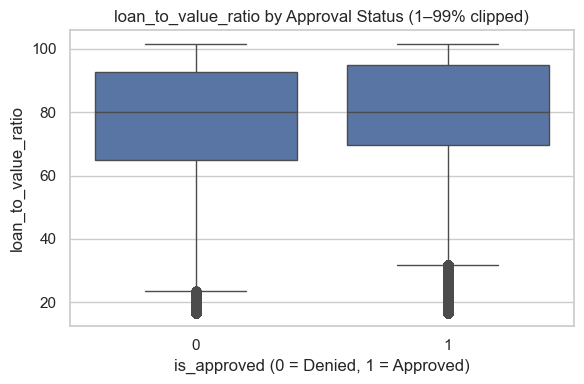

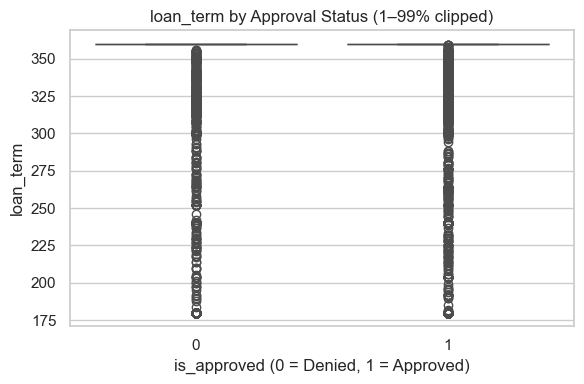

In [31]:

# 5.4: For each numeric feature, show distribution by approval status on transformed scale
for col in key_numeric:
    subset = df[[col, "is_approved"]].dropna()
  
    plot_series, t_label = make_plot_series(col, subset[col])
    tmp = subset.copy()
    tmp[f"{col}_plot"] = plot_series

    plt.figure(figsize=(6, 4))
    sns.boxplot(
        data=tmp,
        x="is_approved",
        y=f"{col}_plot"
    )
    plt.title(f"{col} by Approval Status ({t_label})")
    plt.xlabel("is_approved (0 = Denied, 1 = Approved)")
    plt.ylabel(col)

    plt.tight_layout()
    plt.show()


#### 5a. Outlier Treatment & Feature-Type Engineering Strategy

The features `loan_amount`, `income`, `property_value`, and `loan_to_value_ratio` are treated as continuous numeric variables. Although each contains a moderate percentage of extreme values (≈4–8% of records under an IQR rule), to preserve sample size and reduce distortion from long right tails, we cap each variable at the **1st and 99th percentiles (winsorization)** prior to modeling. This retains the majority of statistical information while limiting undue influence from extreme tails.

In contrast, `loan_term` represents a **finite set of mortgage product options** (e.g., 360-month, 180-month), not a naturally scaled continuum. The skew observed in earlier analysis was caused by a true modal concentration at 360 months (the standard 30-year mortgage), while the remaining values reflect other valid term selections rather than anomalous or erroneous data. Modeling this field as a continuous numeric feature would misrepresent its meaning and preserve misleading skew under scaling. Therefore, we **retain the feature but convert it to categorical loan-term buckets** (e.g., `30-year`, `15-year`, `10-year`, `20-year`, `Other`, `Missing`) prior to encoding and model training. This eliminates semantic distortion and allows algorithms to learn from loan-product category effects.


In [32]:


# Variables to cap (continuous, skewed)
cap_cols = [
    "loan_amount",
    "income",
    "property_value",
    "loan_to_value_ratio",
]

print("Column count before drop:", df.shape[1])

# Cap at 1st and 99th percentiles (winsorization) for each cap column
for col in cap_cols:
    if col in df.columns:
        q1 = df[col].quantile(0.01)
        q99 = df[col].quantile(0.99)
        df[col] = df[col].clip(q1, q99)
        print(f"Capped {col}: lower={q1:.2f}, upper={q99:.2f}")

# Convert loan_term into a categorical variable (few discrete loan product categories)
if "loan_term" in df.columns:
    def loan_term_bucket(term):
        if pd.isna(term):
            return "Missing"
        if term == 360:
            return "30-year"
        if term == 180:
            return "15-year"
        if term == 240:
            return "20-year"
        if term == 120:
            return "10-year"
        return "Other"

    df["loan_term"] = df["loan_term"].apply(loan_term_bucket).astype("category")
    print("Converted loan_term to categorical buckets.")

print("Column count after capping:", df.shape[1])
print("Current dtype of loan_term:", df["loan_term"].dtype)


Column count before drop: 52
Capped loan_amount: lower=15000.00, upper=2715000.00
Capped income: lower=0.00, upper=1406.00
Capped property_value: lower=235000.00, upper=4425000.00
Capped loan_to_value_ratio: lower=16.67, upper=101.62
Converted loan_term to categorical buckets.
Column count after capping: 52
Current dtype of loan_term: category


## 6. EDA: Relationships Between Features and Approval

Here we explore how selected numeric and categorical features relate to the approval outcome. Each step includes both a table and a visualization.


In [33]:

# Selected numeric features to compare vs approval
numeric_features = [
    "loan_amount",
    "income",
    "property_value",
    "loan_to_value_ratio",
]

numeric_features = [c for c in numeric_features if c in df.columns]
print("Numeric features used in Section 6:", numeric_features)

# Summary table: numeric features by approval status
num_summary = (
    df.groupby("is_approved")[numeric_features]
      .agg(["mean", "median", "std", "min", "max", "count"])
)

print("Numeric feature summary by approval status (0 = Denied, 1 = Approved):")

# Force 1 decimal place for all numeric values
num_summary = num_summary.applymap(lambda x: f"{x:.1f}" if isinstance(x, (int, float, np.number)) else x)

display(num_summary)



Numeric features used in Section 6: ['loan_amount', 'income', 'property_value', 'loan_to_value_ratio']
Numeric feature summary by approval status (0 = Denied, 1 = Approved):


C:\Users\joshd\AppData\Local\Temp\ipykernel_17892\2923387962.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_summary = num_summary.applymap(lambda x: f"{x:.1f}" if isinstance(x, (int, float, np.number)) else x)


loan_amount                                                    \
                   mean    median       std      min        max     count   
is_approved                                                                 
0              569657.9  475000.0  467241.6  15000.0  2715000.0   44692.0   
1              652998.2  545000.0  450308.4  15000.0  2715000.0  301658.0   

            income                                      property_value  \
              mean median    std  min     max     count           mean   
is_approved                                                              
0            195.7  150.0  199.8  0.0  1406.0   44692.0       979622.5   
1            236.1  171.0  210.9  0.0  1406.0  301658.0       964358.4   

                                                                \
               median       std       min        max     count   
is_approved                                                      
0            745000.0  770568.3  235000.0  4425000.0   44692.0   
1            745000.0  716942.9  235000.0  4425000.0  301658.0   

            loan_to_value_ratio                                      
                           mean median   std   min    max     count  
is_approved                                                          
0                          75.0   80.0  21.1  16.7  101.6   44692.0  
1                          77.3   80.0  19.3  16.7  101.6  301658.0

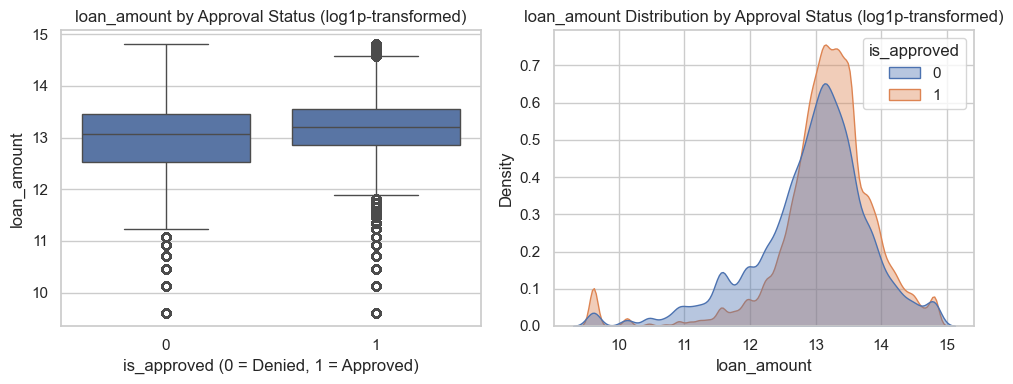

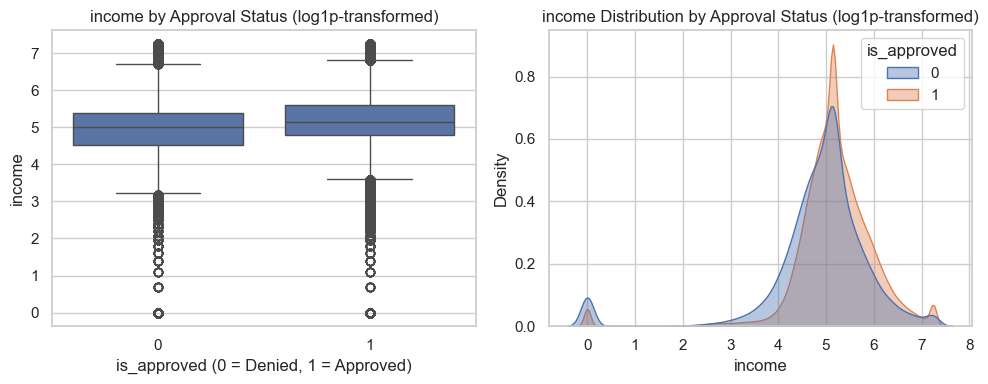

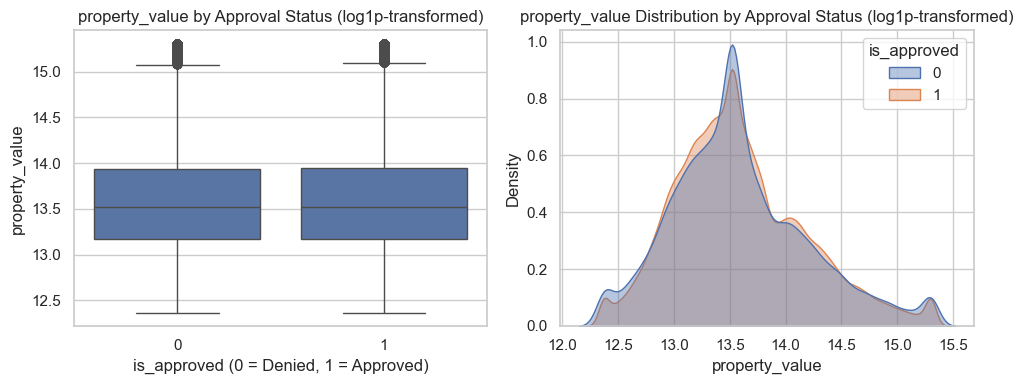

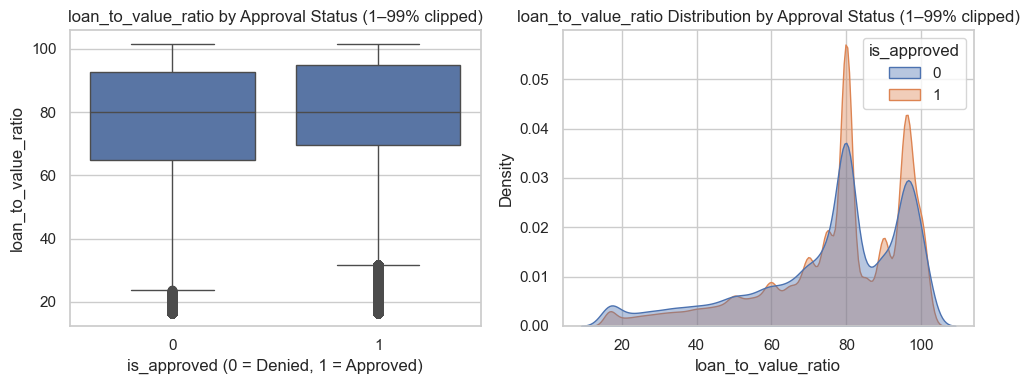

In [34]:
# Helper: transform a series for plotting only  
def make_plot_series(col, series):
    """
    Returns (plot_series, transform_label) for a numeric column.

    - Uses log1p for skewed money-like columns.
    - Uses 1–99% clipping for other numeric features.
    """
    series = series.dropna()

    log_candidates = {"loan_amount", "income", "property_value"}
    if col in log_candidates:
        plot_series = np.log1p(series)
        label = "log1p-transformed"
    else:
        lower = series.quantile(0.01)
        upper = series.quantile(0.99)
        plot_series = series.clip(lower, upper)
        label = "1–99% clipped"

    return plot_series, label


# Visualization: each numeric feature vs approval status
for col in numeric_features:
    tmp = df[[col, "is_approved"]].dropna()
    if tmp.empty:
        print(f"Skipping {col}: no non-null values.")
        continue

    plot_series, t_label = make_plot_series(col, tmp[col])
    tmp[f"{col}_plot"] = plot_series

    plt.figure(figsize=(10, 4))

    # Boxplot by approval status
    plt.subplot(1, 2, 1)
    sns.boxplot(
        data=tmp,
        x="is_approved",
        y=f"{col}_plot"
    )
    plt.title(f"{col} by Approval Status ({t_label})")
    plt.xlabel("is_approved (0 = Denied, 1 = Approved)")
    plt.ylabel(col)

    # KDE / histogram by approval status
    plt.subplot(1, 2, 2)
    sns.kdeplot(
        data=tmp,
        x=f"{col}_plot",
        hue="is_approved",
        common_norm=False,
        fill=True,
        alpha=0.4
    )
    plt.title(f"{col} Distribution by Approval Status ({t_label})")
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()


In [35]:
  

def show_categorical_eda(df, feature, target="is_approved"):
    """
    Show counts, approval rates, and a bar chart + approval-rate heatmap
    for a single categorical feature vs target.
    Horizontal bar charts are always used for legibility and label alignment.
    """
    if feature not in df.columns:
        print(f"Feature '{feature}' not found in DataFrame.")
        return
    if target not in df.columns:
        print(f"Target '{target}' not found in DataFrame.")
        return

    print(f"\n=== Categorical Feature: {feature} ===")

    # 1) Crosstab counts (full plain-text print)
    ct = pd.crosstab(df[feature], df[target], margins=True)
    print("\nCounts by category and approval status (0 = Denied, 1 = Approved):\n")
    print(ct.to_string())
    print("---------------------------------\n")

    # 2) Approval rates per category (full plain-text print)
    rate = (
        df.groupby(feature)[target]
          .mean()
          .rename("approval_rate")
          .reset_index()
    ).sort_values("approval_rate", ascending=False)

    print("Approval rate by category:\n")
    print(rate.to_string(index=False, float_format=lambda x: f"{x:.1%}"))
    print("---------------------------------\n")

    # 3) Horizontal bar chart of approval rate  
    plt.figure(figsize=(8, max(4, 0.4 * len(rate))))
    sns.barplot(data=rate, x="approval_rate", y=feature, orient="h")
    plt.xlabel("Approval Rate")
    plt.ylabel(feature)
    plt.title(f"Approval Rate by {feature}")
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

    # 4) Conditional approval/denial heatmap
    print("Approval/Denial conditional rate heatmap:\n")

    hm = df[[feature, target]].dropna().copy()
    hm["deny_flag"] = 1 - hm[target]

    heat = hm.groupby(feature)[[target, "deny_flag"]].mean()
    heat.columns = ["approval_rate", "denied_rate"]
    heat = heat.sort_index()

    # Print full, non-scientific, non-scrolling table
    print(heat.to_string(index=True, float_format=lambda x: f"{x:.1%}"))
    print("---------------------------------\n")

    # Plot heatmap
    plt.figure(figsize=(6, max(3, 0.35 * len(heat))))
    sns.heatmap(heat, annot=True, fmt=".2%")
    plt.title(f"{feature}: Conditional Approval/Denial Rates")
    plt.xlabel("Rates")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()




=== Categorical Feature: loan_type ===

Counts by category and approval status (0 = Denied, 1 = Approved):

is_approved      0       1     All
loan_type                         
1            33512  230112  263624
2             8776   49754   58530
3             2331   21459   23790
4               73     333     406
All          44692  301658  346350
---------------------------------

Approval rate by category:

 loan_type  approval_rate
         3          90.2%
         1          87.3%
         2          85.0%
         4          82.0%
---------------------------------



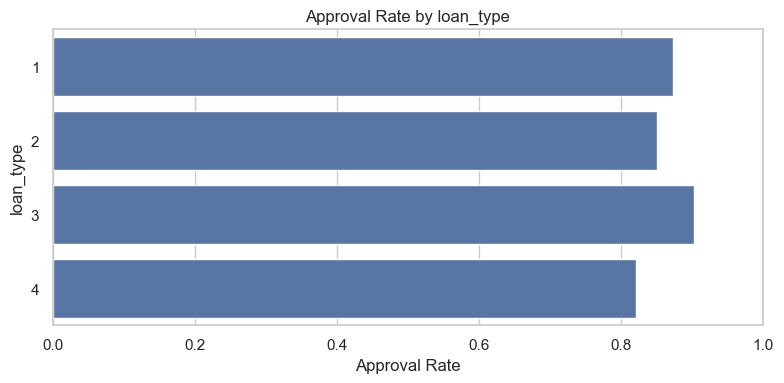

Approval/Denial conditional rate heatmap:

           approval_rate  denied_rate
loan_type                            
1                  87.3%        12.7%
2                  85.0%        15.0%
3                  90.2%         9.8%
4                  82.0%        18.0%
---------------------------------



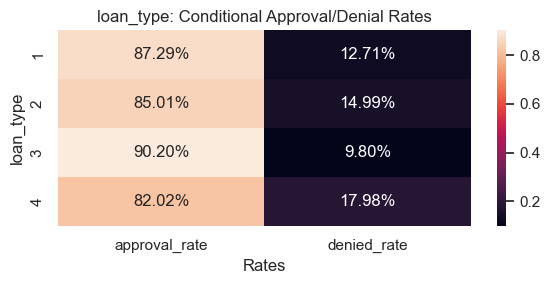

In [36]:
show_categorical_eda(df, "loan_type")


=== Categorical Feature: loan_purpose ===

Counts by category and approval status (0 = Denied, 1 = Approved):

is_approved       0       1     All
loan_purpose                       
1             25987  241912  267899
31            18705   59746   78451
All           44692  301658  346350
---------------------------------

Approval rate by category:

 loan_purpose  approval_rate
            1          90.3%
           31          76.2%
---------------------------------



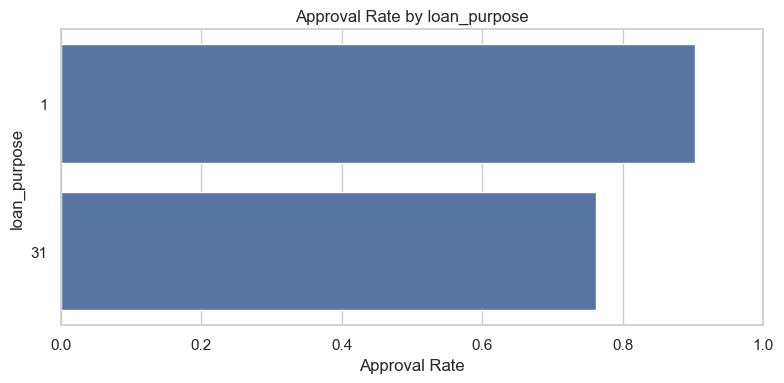

Approval/Denial conditional rate heatmap:

              approval_rate  denied_rate
loan_purpose                            
1                     90.3%         9.7%
31                    76.2%        23.8%
---------------------------------



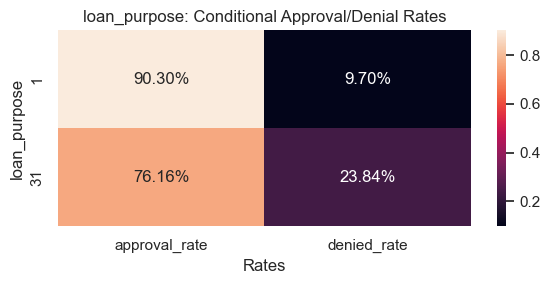

In [37]:
show_categorical_eda(df, "loan_purpose")



=== Categorical Feature: occupancy_type ===

Counts by category and approval status (0 = Denied, 1 = Approved):

is_approved         0       1     All
occupancy_type                       
1               42360  285444  327804
2                 820    5857    6677
3                1512   10357   11869
All             44692  301658  346350
---------------------------------

Approval rate by category:

 occupancy_type  approval_rate
              2          87.7%
              3          87.3%
              1          87.1%
---------------------------------



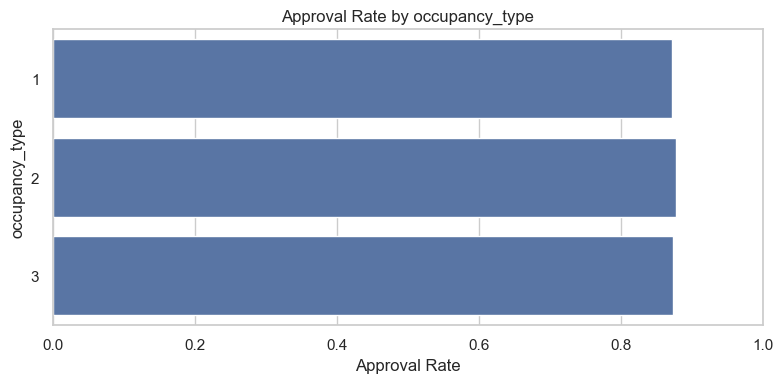

Approval/Denial conditional rate heatmap:

                approval_rate  denied_rate
occupancy_type                            
1                       87.1%        12.9%
2                       87.7%        12.3%
3                       87.3%        12.7%
---------------------------------



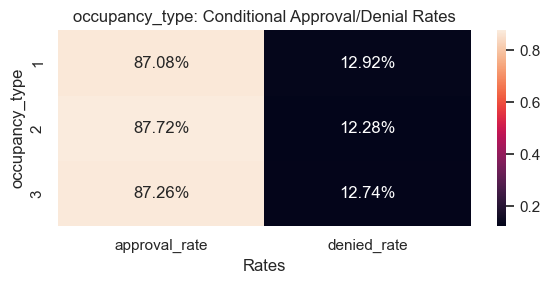

In [38]:
show_categorical_eda(df, "occupancy_type")



=== Categorical Feature: loan_term ===

Counts by category and approval status (0 = Denied, 1 = Approved):

is_approved      0       1     All
loan_term                         
10-year        356    1270    1626
15-year        862    5154    6016
20-year        977    2652    3629
30-year      40583  287648  328231
Other         1914    4934    6848
All          44692  301658  346350
---------------------------------

Approval rate by category:

loan_term  approval_rate
  30-year          87.6%
  15-year          85.7%
  10-year          78.1%
  20-year          73.1%
    Other          72.1%
---------------------------------



C:\Users\joshd\AppData\Local\Temp\ipykernel_17892\2111876658.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(feature)[target]


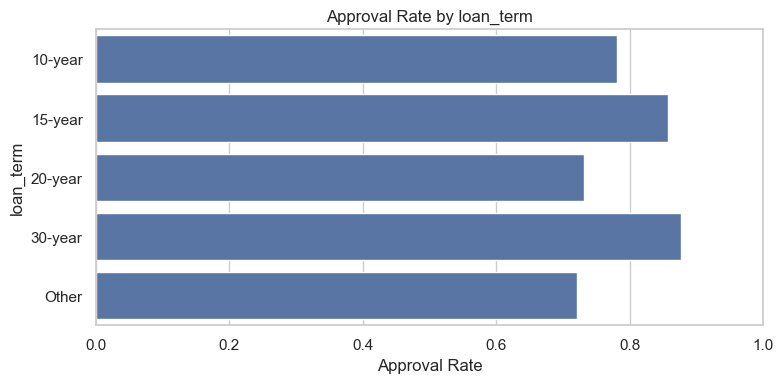

C:\Users\joshd\AppData\Local\Temp\ipykernel_17892\2111876658.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heat = hm.groupby(feature)[[target, "deny_flag"]].mean()


Approval/Denial conditional rate heatmap:

           approval_rate  denied_rate
loan_term                            
10-year            78.1%        21.9%
15-year            85.7%        14.3%
20-year            73.1%        26.9%
30-year            87.6%        12.4%
Other              72.1%        27.9%
---------------------------------



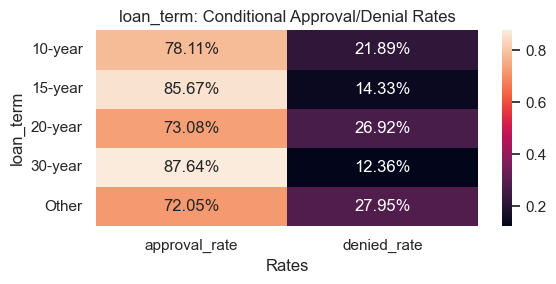

In [39]:
show_categorical_eda(df, "loan_term")



=== Categorical Feature: derived_ethnicity ===

Counts by category and approval status (0 = Denied, 1 = Approved):

is_approved                  0       1     All
derived_ethnicity                             
Ethnicity Not Available   9480   56842   66322
Free Form Text Only         35     202     237
Hispanic or Latino       11111   64085   75196
Joint                     1549   14003   15552
Not Hispanic or Latino   22517  166526  189043
All                      44692  301658  346350
---------------------------------

Approval rate by category:

      derived_ethnicity  approval_rate
                  Joint          90.0%
 Not Hispanic or Latino          88.1%
Ethnicity Not Available          85.7%
    Free Form Text Only          85.2%
     Hispanic or Latino          85.2%
---------------------------------



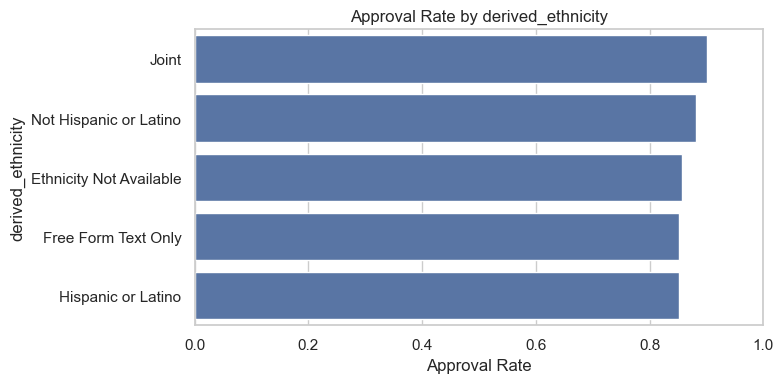

Approval/Denial conditional rate heatmap:

                         approval_rate  denied_rate
derived_ethnicity                                  
Ethnicity Not Available          85.7%        14.3%
Free Form Text Only              85.2%        14.8%
Hispanic or Latino               85.2%        14.8%
Joint                            90.0%        10.0%
Not Hispanic or Latino           88.1%        11.9%
---------------------------------



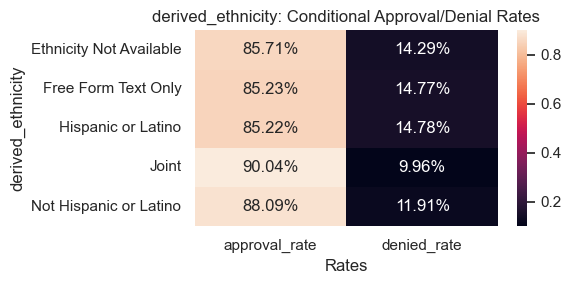

In [40]:
show_categorical_eda(df, "derived_ethnicity")



=== Categorical Feature: derived_race ===

Counts by category and approval status (0 = Denied, 1 = Approved):

is_approved                                    0       1     All
derived_race                                                    
2 or more minority races                     154     822     976
American Indian or Alaska Native             417    2166    2583
Asian                                       8190   62056   70246
Black or African American                   2312    9713   12025
Free Form Text Only                           54      57     111
Joint                                       1253   12322   13575
Native Hawaiian or Other Pacific Islander    224     926    1150
Race Not Available                         11712   68326   80038
White                                      20376  145270  165646
All                                        44692  301658  346350
---------------------------------

Approval rate by category:

                             derived_race  ap

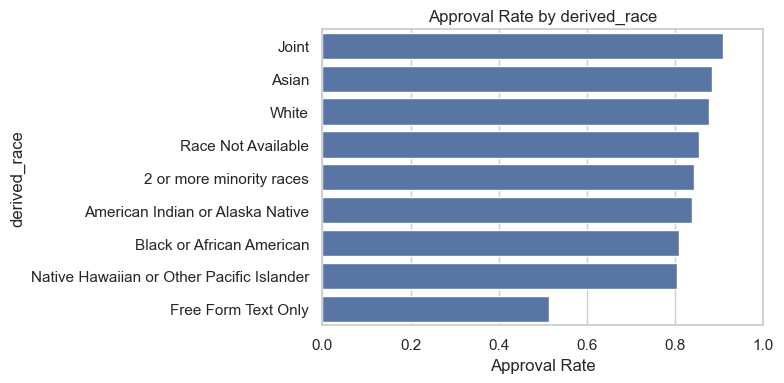

Approval/Denial conditional rate heatmap:

                                           approval_rate  denied_rate
derived_race                                                         
2 or more minority races                           84.2%        15.8%
American Indian or Alaska Native                   83.9%        16.1%
Asian                                              88.3%        11.7%
Black or African American                          80.8%        19.2%
Free Form Text Only                                51.4%        48.6%
Joint                                              90.8%         9.2%
Native Hawaiian or Other Pacific Islander          80.5%        19.5%
Race Not Available                                 85.4%        14.6%
White                                              87.7%        12.3%
---------------------------------



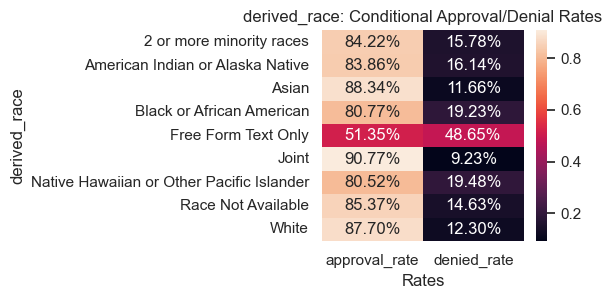

In [41]:


show_categorical_eda(df, "derived_race")



=== Categorical Feature: derived_sex ===

Counts by category and approval status (0 = Denied, 1 = Approved):

is_approved            0       1     All
derived_sex                             
Female              9443   56160   65603
Joint              15588  133347  148935
Male               15700   91380  107080
Sex Not Available   3961   20771   24732
All                44692  301658  346350
---------------------------------

Approval rate by category:

      derived_sex  approval_rate
            Joint          89.5%
           Female          85.6%
             Male          85.3%
Sex Not Available          84.0%
---------------------------------



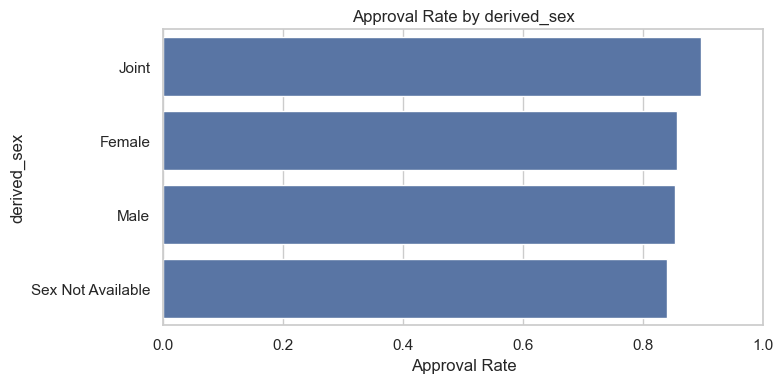

Approval/Denial conditional rate heatmap:

                   approval_rate  denied_rate
derived_sex                                  
Female                     85.6%        14.4%
Joint                      89.5%        10.5%
Male                       85.3%        14.7%
Sex Not Available          84.0%        16.0%
---------------------------------



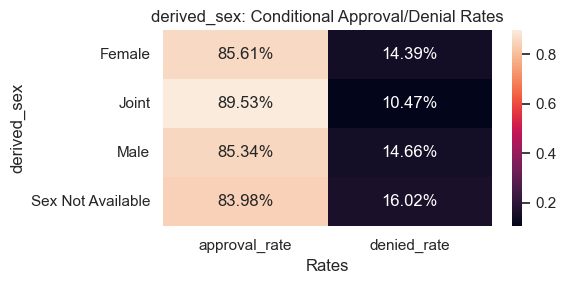

In [42]:
show_categorical_eda(df, "derived_sex")


## 7. Feature Engineering & Categorical Encoding

In this step, we:

- Ensure important engineered features are present (e.g., `loan_to_income`, jumbo flag).  
- Separate predictor (feature_cols) and target (target_col).  
- Use **one-hot encoding** in pipeline definition so that the baseline model can use both numeric and categorical information.


In [43]:

# Work on a modeling copy to avoid mutating the main EDA df
df_model = df.copy()
print("df_model shape before feature engineering:", df_model.shape)

# 7.1 Engineered features

# 7.1.1 loan_to_income: ratio of loan amount to reported income
# Note: HMDA income is typically reported in thousands of dollars.
if "loan_amount" in df_model.columns and "income" in df_model.columns:
    income_safe = df_model["income"].replace({0: np.nan})
    df_model["loan_to_income"] = df_model["loan_amount"] / income_safe
    df_model["loan_to_income"] = df_model["loan_to_income"].replace([np.inf, -np.inf], np.nan)
    print("Engineered feature created: loan_to_income")
else:
    print("Warning: loan_amount and/or income missing; loan_to_income not created.")

# 7.1.2 is_jumbo: flag loans above conforming limit (non-conforming)
# HMDA conforming_loan_limit values like "C" (conforming), "NC" (non-conforming)
if "conforming_loan_limit" in df_model.columns:
    df_model["is_jumbo"] = np.where(
        df_model["conforming_loan_limit"].str.upper().eq("NC"),
        1,
        0
    ).astype("int8")
    print("Engineered feature created: is_jumbo")
else:
    print("Warning: conforming_loan_limit missing; is_jumbo not created.")

print("df_model shape after feature engineering:", df_model.shape)

# 7.2 Feature type identification for encoding

target_col = "is_approved"
assert target_col in df_model.columns, "Target column 'is_approved' is missing."

# Exclude target and any known leakage/non-predictive columns
exclude_cols = {target_col}

feature_cols = [c for c in df_model.columns if c not in exclude_cols]
X_all = df_model[feature_cols]

numeric_features = X_all.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_all.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numeric feature count:", len(numeric_features))
print("Categorical feature count:", len(categorical_features))

# 7.3 Preprocessing: imputation + one-hot encoding (definition only here)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
     ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))

])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

print("Preprocessing pipeline defined.")


df_model shape before feature engineering: (346350, 52)
Engineered feature created: loan_to_income
Engineered feature created: is_jumbo
df_model shape after feature engineering: (346350, 54)
Numeric feature count: 43
Categorical feature count: 10
Preprocessing pipeline defined.


## 8. Train/Test Split & Baseline Logistic Regression

We now:

1. Split the data into **training** and **test** sets (with stratification on the target).   
2. Train a **Logistic Regression** model using both numeric and encoded categorical features.  
3. Evaluate the model with metrics that will also serve as our **baseline for future model comparison**.




In [44]:



# 8.1 Define X and y using df_model and feature_cols from Section 7

X = df_model[feature_cols]
y = df_model[target_col]

print("Final feature matrix shape (X):", X.shape)
print("Target vector length (y):", len(y))

# 8.2 Train/test split (stratified on approval status)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y,
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# 8.3 Baseline model: Logistic Regression with preprocessing

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000, n_jobs=-1))
])

# Fit baseline model

start = time.time()
clf.fit(X_train, y_train)
baseline_train_time = time.time() - start
print(f"Baseline Logistic Regression fit time (seconds): {baseline_train_time:.1f}")

# 8.4 Initialize shared containers
# These will be reused  for other models.
model_results = []

fitted_models = {}

# Register the fitted baseline model for later reference/comparison
fitted_models["Logistic Regression (2024 only)"] = clf



Final feature matrix shape (X): (346350, 53)
Target vector length (y): 346350
Training set size: (259762, 53)
Test set size: (86588, 53)
Baseline Logistic Regression fit time (seconds): 13.6


## 9. Evaluation Metric Choice & Justification

For future model optimization, we need a **primary evaluation metric** to compare models, along with several supporting metrics.

### Primary metric: **F1-score (macro)**

- The dataset may exhibit some imbalance between approved and denied applications.  
- We care about the performance on **both classes**:
  - Approving qualified borrowers (true positives)  
  - Correctly identifying denials (true negatives / avoiding false approvals)  
- The **F1-score (macro)** averages F1 across both classes and balances **precision** and **recall**, making it an appropriate primary metric when both types of error matter.

### Supporting metrics:

- **ROC-AUC**:  
  - Summarizes the model's ability to rank approved vs denied cases across thresholds.  
  - Useful for threshold tuning later and for communicating model performance to stakeholders.

- **Class-specific precision & recall**:  
  - Particularly important for the **denied** class, since false approvals may be costly in a lending context.  

In later phases, when trying alternative models (KNN, Decision Tree, SVM) and tuned hyperparameters, we will:

- Use **macro F1-score** as the primary comparison metric.  
- Monitor **ROC-AUC** and the **confusion matrix** to ensure that improvements are not coming at the expense of unacceptable errors on key classes.

 


=== Baseline Logistic Regression Performance ===
Accuracy:  0.952
F1-score:  0.972
ROC AUC:   0.986

Train time (seconds): 13.6

=== Classification Report ===
              precision    recall  f1-score   support

           0      0.800     0.832     0.816     11173
           1      0.975     0.969     0.972     75415

    accuracy                          0.952     86588
   macro avg      0.888     0.901     0.894     86588
weighted avg      0.952     0.952     0.952     86588

=== Confusion Matrix (raw counts) ===
[[ 9297  1876]
 [ 2323 73092]]


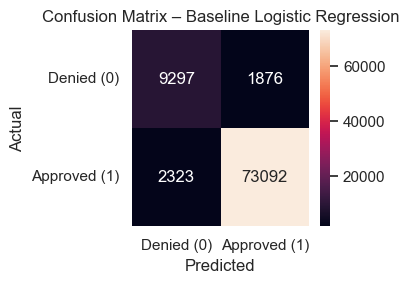


=== Stored Baseline Results (for use in Section 11) ===


,model,accuracy,f1_score,roc_auc,train_time_sec
0,Logistic Regression (2024 only),0.951506,0.972078,0.985597,13.619391


In [45]:
# 9.1 Predictions and probabilities

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# 9.2 Core metrics

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("=== Baseline Logistic Regression Performance ===")
print(f"Accuracy:  {acc:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"ROC AUC:   {auc:.3f}\n")
print(f"Train time (seconds): {baseline_train_time:.1f}\n")  # ← add this

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=3))

print("=== Confusion Matrix (raw counts) ===")
print(confusion_matrix(y_test, y_pred))

# 9.3 Confusion matrix graphic

cm = confusion_matrix(y_test, y_pred)
labels = ["Denied (0)", "Approved (1)"]

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d")
plt.xticks([0.5, 1.5], labels, rotation=0)
plt.yticks([0.5, 1.5], labels, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Baseline Logistic Regression")
plt.tight_layout()
plt.show()

# 9.4 Persist baseline metrics for later comparison 

baseline_entry = {
    "model": "Logistic Regression (2024 only)",
    "accuracy": acc,
    "f1_score": f1,
    "roc_auc": auc,
    "train_time_sec": baseline_train_time,
}

model_results.append(baseline_entry)

baseline_results_df = pd.DataFrame(model_results)
print("\n=== Stored Baseline Results (for use in Section 11) ===")
display(baseline_results_df)



### Summary of Baseline EDA & Modeling Phase

In this notebook, we:

- Loaded a **filtered HMDA CA 2024** dataset for single-family, non-business, home-purchase/refinance loans.  
- Verified and documented the decision to **restrict modeling** to `action_taken` ∈ {1, 2, 3}, representing completed underwriting decisions only.  
- Defined a binary target `is_approved` (1 for approved decisions; 0 for denials).  
- Conducted **missing data analysis** and implemented a **justified imputation strategy** (median for numeric, mode for categorical).  
- Performed **outlier analysis** on key numeric fields, visualized distributions, and applied **winsorization (capping)** to reduce the influence of extreme values while retaining records.  
- Explored relationships between features and the target using **both tables and visualizations** (boxplots, histograms, stacked bar charts, correlation heatmap).  
- Engineered additional features (e.g., `loan_to_income`, `is_jumbo`) and encoded categorical variables via **one-hot encoding**.  
- Trained a **baseline Logistic Regression model** using both numeric and categorical predictors.  
- Evaluated the baseline using **classification report, confusion matrix, and ROC-AUC**, and selected **macro F1-score** as the primary metric for future model comparison, with ROC-AUC and class-specific metrics as supporting measures.

This establishes a **well-documented, EDA-driven baseline** against which future, more complex models (KNN, Decision Tree, SVM, tuned Logistic Regression, etc.) can be fairly compared.


## 10. Prepare Data for 3 year evaluation

- Above steps evaluated only on the 2024 data for California
- Below will repeat the same data cleaning steps, but applied to 2022-2024 data


### 10a. Load 3 years of data

In [46]:

# Define file paths (adjust filenames if they differ)
paths = [
    "data/state_CA_2022_filtered.csv",
    "data/state_CA_2023_filtered.csv",
    "data/state_CA_2024_filtered.csv",
]

# Read and concatenate all years in the same order
frames = []
for p in paths:
    temp = pd.read_csv(p, low_memory=False)
    print(f"{p} shape:", temp.shape)
    frames.append(temp)

df_3year = pd.concat(frames, axis=0, ignore_index=True)

print("Merged DataFrame shape (2022 → 2024):", df_3year.shape)



data/state_CA_2022_filtered.csv shape: (500547, 99)
data/state_CA_2023_filtered.csv shape: (293285, 99)
data/state_CA_2024_filtered.csv shape: (346350, 100)
Merged DataFrame shape (2022 → 2024): (1140182, 100)


### 10b. Engineer is_approved target column

In [47]:
# Create/confirm binary target
df_3year["is_approved"] = df_3year["action_taken"].apply(lambda x: 1 if x in [1, 2] else 0)

df_3year["is_approved"].value_counts(normalize=True) * 100

df_3year = df_3year.drop(columns=["action_taken"], errors="ignore")

df_3year.shape

(1140182, 99)

### 10c. Drop columns identified in baseline EDA

In [48]:
## ---- 3a
df_3year = df_3year.drop(columns=["lei", "preapproval", "derived_dwelling_category", "state_code", "purchaser_type", "business_or_commercial_purpose", "manufactured_home_secured_property_type", "manufactured_home_land_property_interest"], errors="ignore")

## ---- 3b
drop_cols = [c for c in df_3year.columns if "denial_reason" in c.lower()]
df_3year = df_3year.drop(columns=drop_cols, errors="ignore")

## ---- 3c
cols = [
    "total_loan_costs", 
    "rate_spread", 
    "interest_rate", 
    "origination_charges", 
    "discount_points", 
    "lender_credits", 
    "total_points_and_fees"
]
df_3year = df_3year.drop(columns=[c for c in cols if c in df_3year.columns])


## ---- 4a
drop_cols = [c for c in df_3year.columns if "ethnicity" in c.lower() and df_3year[c].isna().mean()*100 > 0]
df_3year = df_3year.drop(columns=drop_cols)

## ---- 4b
drop_cols = [c for c in df_3year.columns if "race" in c.lower() and df_3year[c].isna().mean()*100 > 0]
df_3year = df_3year.drop(columns=drop_cols)

## ---- 4c
drop_cols = [c for c in df_3year.columns if "aus-" in c.lower() and df_3year[c].isna().mean()*100 > 5]
df_3year = df_3year.drop(columns=drop_cols)

## ---- 4d
missing_pct = df_3year.isna().mean() * 100
drop_cols = [c for c in df_3year.columns if missing_pct[c] > 10 and c != "is_approved"]
df_3year = df_3year.drop(columns=drop_cols)

df_3year.shape

(1140182, 52)

### 10d. Coerce objects to float type

In [49]:
# Coerce object → numeric, invalid strings become NaN
df_3year["property_value"] = pd.to_numeric(df_3year["property_value"], errors="coerce")

# Convert resulting numeric dtype to float (if not already)
df_3year["property_value"] = df_3year["property_value"].astype(float)

print("property_value dtype after conversion:", df_3year["property_value"].dtype)
print("Min:", df_3year["property_value"].min(), "Max:", df_3year["property_value"].max())

# Coerce to numeric (invalid strings → NaN)
df_3year["loan_to_value_ratio"] = pd.to_numeric(df_3year["loan_to_value_ratio"], errors="coerce")

# Ensure float dtype
df_3year["loan_to_value_ratio"] = df_3year["loan_to_value_ratio"].astype(float)

print("loan_to_value_ratio dtype after conversion:", df_3year["loan_to_value_ratio"].dtype)
print("Min:", df_3year["loan_to_value_ratio"].min(), "Max:", df_3year["loan_to_value_ratio"].max())

property_value dtype after conversion: float64
Min: 5000.0 Max: 1079135000.0
loan_to_value_ratio dtype after conversion: float64
Min: 0.01 Max: 113636.36


### 10e. Review remaining missingness of attributes

In [50]:
# Missing values per column
missing_counts = df_3year.isna().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(df_3year) * 100).round(2)

# Build report and filter to only columns with missing_pct > 0
missing_df = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_pct": missing_pct
})
missing_df = missing_df[missing_df["missing_pct"] > 0]  # <- keep only non-zero missingness

# Print / display top 20 of remaining columns
missing_df.head(20)

,missing_count,missing_pct
debt_to_income_ratio,68953,6.050000
loan_to_value_ratio,57011,5.000000
income,36606,3.210000
loan_term,28101,2.460000
property_value,22164,1.940000
census_tract,4558,0.400000
county_code,3648,0.320000
applicant_age_above_62,1524,0.130000


### 10f. Impute values for missing attibutes

In [51]:
# Example: ensure no missing target
df_3year = df_3year[df_3year["is_approved"].notna()].copy()

numeric_cols = df_3year.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != "is_approved"]

categorical_cols = df_3year.select_dtypes(include=["object", "category"]).columns.tolist()

# Median imputation for numeric columns
for col in numeric_cols:
    if df_3year[col].isna().any():
        median_val = df_3year[col].median()
        df_3year[col] = df_3year[col].fillna(median_val)

# Mode / 'Missing' imputation for categorical columns
for col in categorical_cols:
    if df_3year[col].isna().any():
        mode_val = df_3year[col].mode(dropna=True)
        if len(mode_val) > 0:
            df_3year[col] = df_3year[col].fillna(mode_val[0])
        else:
            df_3year[col] = df_3year[col].fillna("Missing")

# Confirm missingness handled
(df_3year.isna().sum() == 0).all()

np.True_

### 10g. Cap outliers and convert loan_term to category

In [52]:

# Variables to cap (continuous, skewed)
cap_cols = [
    "loan_amount",
    "income",
    "property_value",
    "loan_to_value_ratio",
]

# Cap at 1st and 99th percentiles (winsorization) for each cap column
for col in cap_cols:
    if col in df_3year.columns:
        q1 = df_3year[col].quantile(0.01)
        q99 = df_3year[col].quantile(0.99)
        df_3year[col] = df_3year[col].clip(q1, q99)
        print(f"Capped {col}: lower={q1:.2f}, upper={q99:.2f}")

# Convert loan_term into a categorical variable (few discrete loan product categories)
if "loan_term" in df_3year.columns:
    def loan_term_bucket(term):
        if pd.isna(term):
            return "Missing"
        if term == 360:
            return "30-year"
        if term == 180:
            return "15-year"
        if term == 240:
            return "20-year"
        if term == 120:
            return "10-year"
        return "Other"

    df_3year["loan_term"] = df_3year["loan_term"].apply(loan_term_bucket).astype("category")
    print("Converted loan_term to categorical buckets.")

print("Column count after capping:", df_3year.shape[1])
print("Current dtype of loan_term:", df_3year["loan_term"].dtype)


Capped loan_amount: lower=15000.00, upper=2705000.00
Capped income: lower=3.00, upper=1277.00
Capped property_value: lower=225000.00, upper=4505000.00
Capped loan_to_value_ratio: lower=15.79, upper=101.96
Converted loan_term to categorical buckets.
Column count after capping: 52
Current dtype of loan_term: category


### 10h. Engineer loan_to_income and  is_jumbo attributes, copy to df_model

In [53]:

# Work on a modeling copy to avoid mutating the main EDA df
df_model = df_3year.copy()

#  Engineered features

# loan_to_income: ratio of loan amount to reported income
# Note: HMDA income is typically reported in thousands of dollars.
if "loan_amount" in df_model.columns and "income" in df_model.columns:
    income_safe = df_model["income"].replace({0: np.nan})
    df_model["loan_to_income"] = df_model["loan_amount"] / income_safe
    df_model["loan_to_income"] = df_model["loan_to_income"].replace([np.inf, -np.inf], np.nan)
    print("Engineered feature created: loan_to_income")
else:
    print("Warning: loan_amount and/or income missing; loan_to_income not created.")

# is_jumbo: flag loans above conforming limit (non-conforming)
# HMDA conforming_loan_limit values like "C" (conforming), "NC" (non-conforming)
if "conforming_loan_limit" in df_model.columns:
    df_model["is_jumbo"] = np.where(
        df_model["conforming_loan_limit"].str.upper().eq("NC"),
        1,
        0
    ).astype("int8")
    print("Engineered feature created: is_jumbo")
else:
    print("Warning: conforming_loan_limit missing; is_jumbo not created.")

print("df_model shape after feature engineering:", df_model.shape)


Engineered feature created: loan_to_income
Engineered feature created: is_jumbo
df_model shape after feature engineering: (1140182, 54)


In [54]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140182 entries, 0 to 1140181
Data columns (total 54 columns):
 #   Column                             Non-Null Count    Dtype   
---  ------                             --------------    -----   
 0   activity_year                      1140182 non-null  int64   
 1   derived_msa-md                     1140182 non-null  int64   
 2   county_code                        1140182 non-null  float64 
 3   census_tract                       1140182 non-null  float64 
 4   conforming_loan_limit              1140182 non-null  object  
 5   derived_loan_product_type          1140182 non-null  object  
 6   derived_ethnicity                  1140182 non-null  object  
 7   derived_race                       1140182 non-null  object  
 8   derived_sex                        1140182 non-null  object  
 9   loan_type                          1140182 non-null  int64   
 10  loan_purpose                       1140182 non-null  int64   
 11  lien_status

### 10i. Define test and train data sets

In [55]:
# Feature type identification for encoding

target_col = "is_approved"
assert target_col in df_model.columns, "Target column 'is_approved' is missing."

# Exclude target and any known leakage/non-predictive columns
exclude_cols = {target_col}

feature_cols = [c for c in df_model.columns if c not in exclude_cols]
X_all = df_model[feature_cols]

numeric_features = X_all.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_all.select_dtypes(include=["object", "category"]).columns.tolist()

# Define X and y using df_model and feature_cols from Section 7

X = df_model[feature_cols]
y = df_model[target_col]

print("Final feature matrix shape (X):", X.shape)
print("Target vector length (y):", len(y))

# Train/test split (stratified on approval status)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y,
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)



Final feature matrix shape (X): (1140182, 53)
Target vector length (y): 1140182
Training set size: (855136, 53)
Test set size: (285046, 53)


## 11. Perform model fit over 3 year 




In [56]:
# 11. Model Comparison (Algorithm Benchmarking)

from sklearn.svm import LinearSVC

# Additional baseline candidate models (submission-time features only, no tuning)
model_defs = {
    "Logistic Regression (Baseline)": LogisticRegression(max_iter=1000, n_jobs=-1),
    "KNN (Baseline)": KNeighborsClassifier(n_jobs=-1),
    "Decision Tree (Baseline)": DecisionTreeClassifier(random_state=42),
    "Linear SVM (Baseline)": LinearSVC(max_iter=2000, random_state=42),
}

# Benchmark loop
for name, estimator in model_defs.items():
    print(f"\n=== Benchmarking: {name} ===")

    # Build pipeline with shared preprocess
    model_pipeline = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", estimator),
    ])
    
    # Fit + time training
    start_time = time.time()
    model_pipeline.fit(X_train, y_train)
    train_time_sec = round(time.time() - start_time, 1)

    # Save fitted model
    fitted_models[name] = model_pipeline

    # Predictions
    start_pred = time.time()
    y_pred = model_pipeline.predict(X_test)
    pred_time_sec = round(time.time() - start_pred, 1)

    print(f"{name} – train_time_sec: {train_time_sec}, pred_time_sec: {pred_time_sec}")

    # Scores for ROC AUC via decision_function or predict_proba fallback
    model = model_pipeline.named_steps["model"]
    if hasattr(model, "decision_function"):
        y_scores = model_pipeline.decision_function(X_test)
    else:
        # Only for models that truly lack decision_function (rare here)
        y_scores = model_pipeline.predict_proba(X_test)[:, 1]

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_scores)

    # Persist benchmark metrics
    model_results.append({
        "model": name,
        "accuracy": round(acc, 4),
        "f1_score": round(f1, 4),
        "roc_auc": round(auc, 4),
        "train_time_sec": train_time_sec,
    })

    # Print baseline report
    print(f"Train time (sec): {train_time_sec}")
    print(classification_report(y_test, y_pred, digits=3))

# Final aggregated comparison table (baseline LR + new benchmarks)
results_df = pd.DataFrame(model_results)

print("\n=== Section 11: Aggregated Baseline Results ===")
display(results_df)




=== Benchmarking: Logistic Regression (Baseline) ===
Logistic Regression (Baseline) – train_time_sec: 34.1, pred_time_sec: 1.5
Train time (sec): 34.1
              precision    recall  f1-score   support

           0      0.798     0.826     0.811     37576
           1      0.973     0.968     0.971    247470

    accuracy                          0.949    285046
   macro avg      0.886     0.897     0.891    285046
weighted avg      0.950     0.949     0.950    285046


=== Benchmarking: KNN (Baseline) ===
KNN (Baseline) – train_time_sec: 11.1, pred_time_sec: 1162.9
Train time (sec): 11.1
              precision    recall  f1-score   support

           0      0.777     0.762     0.769     37576
           1      0.964     0.967     0.965    247470

    accuracy                          0.940    285046
   macro avg      0.870     0.864     0.867    285046
weighted avg      0.939     0.940     0.939    285046


=== Benchmarking: Decision Tree (Baseline) ===
Decision Tree (Baseline) 

,model,accuracy,f1_score,roc_auc,train_time_sec
0,Logistic Regression (2024 only),0.951506,0.972078,0.985597,13.619391
1,Logistic Regression (Baseline),0.949400,0.970800,0.984200,34.100000
2,KNN (Baseline),0.939700,0.965300,0.958000,11.100000
3,Decision Tree (Baseline),0.949400,0.970900,0.888400,26.800000
4,Linear SVM (Baseline),0.949100,0.970600,0.983900,86.200000


## 12. Hyperparameter Tuning (Grid Search, ROC AUC Optimized)


In [59]:
# --------------------------------------------------
# 12.0 Build a smaller stratified sample for tuning (CV only)
# --------------------------------------------------

CV_SAMPLE = 20000  # max rows to use for hyperparameter tuning CV

if len(df_model) > CV_SAMPLE:
    # Stratified down-sample by target to preserve class balance
    df_cv = (
        df_model
        .groupby(target_col, group_keys=False)
        .apply(
            lambda x: x.sample(
                n=max(1, int(CV_SAMPLE * len(x) / len(df_model))), 
                random_state=42
            )
        )
    )
    print(f"Using stratified CV sample of size: {df_cv.shape}")
else:
    df_cv = df_model.copy()
    print(f"Dataset smaller than CV_SAMPLE; using full df_model for tuning: {df_cv.shape}")

X_cv = df_cv[feature_cols]
y_cv = df_cv[target_col]

# --------------------------------------------------
# Containers for tuned model results and best estimators
# --------------------------------------------------

tuned_results = []
tuned_models = {}

# --------------------------------------------------
# 12.1 Define models and parameter grids
# --------------------------------------------------

models_to_tune = {
    "Logistic Regression (Tuned)": (
        LogisticRegression(max_iter=2000, n_jobs=-1),
        {
            "model__C": [0.01, 0.1, 1.0, 10.0],
            "model__penalty": ["l2"],
            "model__solver": ["lbfgs"],
        },
    ),
    "KNN (Tuned)": (
        KNeighborsClassifier(),
        {
            # Slightly trimmed grid to reduce runtime
            "model__n_neighbors": [5, 15],
            "model__weights": ["uniform", "distance"],
            "model__p": [1, 2],  # 1 = manhattan, 2 = euclidean
        },
    ),
    "Decision Tree (Tuned)": (
        DecisionTreeClassifier(random_state=42),
        {
            "model__max_depth": [5, 10, 20, None],
            "model__min_samples_split": [2, 10, 50],
            "model__min_samples_leaf": [1, 5, 20],
            "model__criterion": ["gini", "entropy"],
        },
    ),
    "Linear SVM (Tuned)": (
        LinearSVC(max_iter=5000, random_state=42),
        {
            "model__C": [0.01, 0.1, 1.0, 10.0],
        },
    ),
}

# --------------------------------------------------
# 12.2 GridSearchCV for each model (using CV sample for tuning)
# --------------------------------------------------

for name, (estimator, param_grid) in models_to_tune.items():
    print("\n" + "="*30)
    print(f" Hyperparameter Tuning: {name}")
    print("="*30)

    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", estimator),
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=3,
        n_jobs=-1,
        verbose=2,
    )

    start_time = time.time()
    grid.fit(X_cv, y_cv)   # <-- use the stratified sample for tuning
    tuning_time_sec = round(time.time() - start_time, 1)

    print(f"\nBest params for {name}: {grid.best_params_}")
    print(f"Best CV ROC AUC for {name}: {grid.best_score_:.4f}")
    print(f"Tuning time (seconds): {tuning_time_sec:.1f}")

    best_model = grid.best_estimator_
    tuned_models[name] = best_model

    # Evaluate tuned model on full held-out test set (not just the CV sample)
    y_pred = best_model.predict(X_test)

    model_step = best_model.named_steps["model"]
    if hasattr(model_step, "decision_function"):
        y_scores = best_model.decision_function(X_test)
    else:
        y_scores = best_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_scores)

    print(f"\n=== Test Set Performance: {name} (Tuned) ===")
    print(f"Accuracy:  {acc:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC AUC:   {auc:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=3))

    tuned_results.append({
        "model": name,
        "accuracy": round(acc, 4),
        "f1_score": round(f1, 4),
        "roc_auc": round(auc, 4),
        "tuning_time_sec": tuning_time_sec,
        "best_params": grid.best_params_,
    })

# --------------------------------------------------
# 12.3 Aggregate tuned results table
# --------------------------------------------------

tuned_results_df = pd.DataFrame(tuned_results).sort_values("roc_auc", ascending=False)

print("\n=== Section 12: Tuned Model Results (Test Set, 3-Year Data) ===")
display(tuned_results_df)


C:\Users\joshd\AppData\Local\Temp\ipykernel_17892\3715448932.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


Using stratified CV sample of size: (19999, 54)

 Hyperparameter Tuning: Logistic Regression (Tuned)
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best params for Logistic Regression (Tuned): {'model__C': 10.0, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV ROC AUC for Logistic Regression (Tuned): 0.9839
Tuning time (seconds): 7.1

=== Test Set Performance: Logistic Regression (Tuned) (Tuned) ===
Accuracy:  0.9492
F1-score:  0.9707
ROC AUC:   0.9837

Classification report:
              precision    recall  f1-score   support

           0      0.797     0.825     0.811     37576
           1      0.973     0.968     0.971    247470

    accuracy                          0.949    285046
   macro avg      0.885     0.897     0.891    285046
weighted avg      0.950     0.949     0.950    285046


 Hyperparameter Tuning: KNN (Tuned)
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best params for KNN (Tuned): {'model__n_neighbors': 15, 'model__p': 2, 

,model,accuracy,f1_score,roc_auc,tuning_time_sec,best_params
3,Linear SVM (Tuned),0.949600,0.970900,0.983800,11.000000,{'model__C': 10.0}
0,Logistic Regression (Tuned),0.949200,0.970700,0.983700,7.100000,"{'model__C': 10.0, 'model__penalty': 'l2', 'mo..."
2,Decision Tree (Tuned),0.949800,0.970900,0.982600,19.600000,"{'model__criterion': 'gini', 'model__max_depth..."
1,KNN (Tuned),0.913900,0.952000,0.961300,31.800000,"{'model__n_neighbors': 15, 'model__p': 2, 'mod..."


## 13. Model Selection


In [60]:
# 13. Model Selection & Improvement Deltas


# 13.1 Sanity check: show baseline and tuned frames
print("Baseline results_df (Section 11):")
display(results_df)

print("\nTuned results_df (Section 12):")
display(tuned_results_df)

# 13.2 Define mapping between baseline and tuned model names
# Adjust names here if they differ in your results_df/tuned_results_df
model_family_map = {
    "Logistic Regression": (
        "Logistic Regression (Baseline)",
        "Logistic Regression (Tuned)",
    ),
    "KNN": (
        "KNN (Baseline)",
        "KNN (Tuned)",
    ),
    "Decision Tree": (
        "Decision Tree (Baseline)",
        "Decision Tree (Tuned)",
    ),
    "Linear SVM": (
        "Linear SVM (Baseline)",
        "Linear SVM (Tuned)",
    ),
}

comparison_rows = []

for family, (baseline_name, tuned_name) in model_family_map.items():
    base_row = results_df[results_df["model"] == baseline_name]
    tuned_row = tuned_results_df[tuned_results_df["model"] == tuned_name]

    if base_row.empty:
        print(f"[Warning] Baseline model '{baseline_name}' not found for family '{family}'. Skipping.")
        continue
    if tuned_row.empty:
        print(f"[Warning] Tuned model '{tuned_name}' not found for family '{family}'. Skipping.")
        continue

    b = base_row.iloc[0]
    t = tuned_row.iloc[0]

    comparison_rows.append({
        "family": family,
        "baseline_model": baseline_name,
        "tuned_model": tuned_name,
        "baseline_accuracy": b["accuracy"],
        "tuned_accuracy": t["accuracy"],
        "delta_accuracy": t["accuracy"] - b["accuracy"],
        "baseline_f1": b["f1_score"],
        "tuned_f1": t["f1_score"],
        "delta_f1": t["f1_score"] - b["f1_score"],
        "baseline_roc_auc": b["roc_auc"],
        "tuned_roc_auc": t["roc_auc"],
        "delta_roc_auc": t["roc_auc"] - b["roc_auc"],
        # timing fields (if present)
        "baseline_train_time_sec": b.get("train_time_sec", None),
        "tuned_tuning_time_sec": t.get("tuning_time_sec", None),
        # best params for the tuned model (if present)
        "tuned_best_params": t.get("best_params", None),
    })

comparison_df = pd.DataFrame(comparison_rows)

print("\n=== Section 13: Baseline vs Tuned Model Comparison by Family ===")
# Sort by ROC AUC delta (largest improvement first)
display(comparison_df.sort_values("delta_roc_auc", ascending=False))

# 13.3 Select winner model among all tuned models (highest tuned ROC AUC)
winner_idx = tuned_results_df["roc_auc"].idxmax()
winner_row = tuned_results_df.loc[winner_idx]

print("\n=== Selected 'Winner' Model (Highest Tuned ROC AUC on Test Set) ===")
print(f"Model:       {winner_row['model']}")
print(f"Accuracy:    {winner_row['accuracy']:.4f}")
print(f"F1-score:    {winner_row['f1_score']:.4f}")
print(f"ROC AUC:     {winner_row['roc_auc']:.4f}")
if "tuning_time_sec" in winner_row:
    print(f"Tuning time: {winner_row['tuning_time_sec']:.1f} seconds")
if "best_params" in winner_row:
    print("\nBest hyperparameters:")
    print(winner_row["best_params"])


Baseline results_df (Section 11):


,model,accuracy,f1_score,roc_auc,train_time_sec
0,Logistic Regression (2024 only),0.951506,0.972078,0.985597,13.619391
1,Logistic Regression (Baseline),0.949400,0.970800,0.984200,34.100000
2,KNN (Baseline),0.939700,0.965300,0.958000,11.100000
3,Decision Tree (Baseline),0.949400,0.970900,0.888400,26.800000
4,Linear SVM (Baseline),0.949100,0.970600,0.983900,86.200000



Tuned results_df (Section 12):


,model,accuracy,f1_score,roc_auc,tuning_time_sec,best_params
3,Linear SVM (Tuned),0.949600,0.970900,0.983800,11.000000,{'model__C': 10.0}
0,Logistic Regression (Tuned),0.949200,0.970700,0.983700,7.100000,"{'model__C': 10.0, 'model__penalty': 'l2', 'mo..."
2,Decision Tree (Tuned),0.949800,0.970900,0.982600,19.600000,"{'model__criterion': 'gini', 'model__max_depth..."
1,KNN (Tuned),0.913900,0.952000,0.961300,31.800000,"{'model__n_neighbors': 15, 'model__p': 2, 'mod..."



=== Section 13: Baseline vs Tuned Model Comparison by Family ===


,family,baseline_model,tuned_model,baseline_accuracy,tuned_accuracy,delta_accuracy,baseline_f1,tuned_f1,delta_f1,baseline_roc_auc,tuned_roc_auc,delta_roc_auc,baseline_train_time_sec,tuned_tuning_time_sec,tuned_best_params
2,Decision Tree,Decision Tree (Baseline),Decision Tree (Tuned),0.949400,0.949800,0.000400,0.970900,0.970900,0.000000,0.888400,0.982600,0.094200,26.800000,19.600000,"{'model__criterion': 'gini', 'model__max_depth..."
1,KNN,KNN (Baseline),KNN (Tuned),0.939700,0.913900,-0.025800,0.965300,0.952000,-0.013300,0.958000,0.961300,0.003300,11.100000,31.800000,"{'model__n_neighbors': 15, 'model__p': 2, 'mod..."
3,Linear SVM,Linear SVM (Baseline),Linear SVM (Tuned),0.949100,0.949600,0.000500,0.970600,0.970900,0.000300,0.983900,0.983800,-0.000100,86.200000,11.000000,{'model__C': 10.0}
0,Logistic Regression,Logistic Regression (Baseline),Logistic Regression (Tuned),0.949400,0.949200,-0.000200,0.970800,0.970700,-0.000100,0.984200,0.983700,-0.000500,34.100000,7.100000,"{'model__C': 10.0, 'model__penalty': 'l2', 'mo..."



=== Selected 'Winner' Model (Highest Tuned ROC AUC on Test Set) ===
Model:       Linear SVM (Tuned)
Accuracy:    0.9496
F1-score:    0.9709
ROC AUC:     0.9838
Tuning time: 11.0 seconds

Best hyperparameters:
{'model__C': 10.0}
